##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Embeddings de Palavras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Ver no TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Executar no Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    Ver código fonte no GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/pt-br/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Baixar notebook</a>
  </td>
</table>

Este tutorial apresenta embedding de palavras. Ele contém código completo para treinar combinações de palavras do zero em um pequeno conjunto de dados e para visualizá-las usando o [Embedding Projector] (http://projector.tensorflow.org) (mostrado na imagem abaixo).

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt = "Captura de tela do projetor de embedding" width = "400" />

## Representando texto como números

Os modelos de aprendizado de máquina recebem vetores (matrizes de números) como entrada. Ao trabalhar com texto, a primeira coisa que devemos fazer é criar uma estratégia para converter seqüências de caracteres em números (ou "vetorizar" o texto) antes de alimentá-lo no modelo. Nesta seção, examinaremos três estratégias para fazê-lo.

### Codificações one-hot

Como primeira idéia, podemos "codificar" cada palavra em nosso vocabulário. Considere a frase "The cat sat on the mat". O vocabulário (ou palavras únicas) nesta frase é (cat, mat, on, sat, the). Para representar cada palavra, criaremos um vetor de zeros com comprimento igual ao vocabulário e, em seguida, colocaremos 1 no índice que corresponder à palavra. Essa abordagem é mostrada no diagrama a seguir.

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt = "Diagrama de codificações únicas" width ="400"/>

Para criar um vetor que contenha a codificação da sentença, poderíamos concatenar o vetor one-hot de cada palavra.

Ponto-chave: Essa abordagem é ineficiente. Um vetor one-hot é escasso (ou seja, a maioria das indicações é zero). Imagine que temos 10.000 palavras no vocabulário. Para codificar cada palavra, criaríamos um vetor em que 99,99% dos elementos são zero.

### Codifique cada palavra com um número único

Uma segunda abordagem que podemos tentar é codificar cada palavra usando um número único. Continuando o exemplo acima, poderíamos atribuir 1 a "cat", 2 a "mat" e assim por diante. Poderíamos então codificar a frase "The cat sat on the mat" como um vetor denso como [5, 1, 4, 3, 5, 2]. Esta abordagem é eficiente. Em vez de um vetor esparso, agora temos um denso (onde todos os elementos estão cheios).

No entanto, existem duas desvantagens nessa abordagem:

* A codificação de número inteiro é arbitrária (não captura nenhuma relação entre palavras).

* Uma codificação de número inteiro pode ser desafiadora para um modelo interpretar. Um classificador linear, por exemplo, aprende um único peso para cada recurso. Como não há relação entre a similaridade de duas palavras e a similaridade de suas codificações, essa combinação de peso e característica não tem significado.

### Embeddings de palavras

O embedding de palavras nos fornece uma maneira de usar uma representação eficiente e densa, na qual palavras semelhantes têm uma codificação semelhante. É importante ressaltar que não precisamos especificar essa codificação manualmente. Um embedding é um vetor denso de valores de ponto flutuante (o comprimento do vetor é um parâmetro que você especifica). Em vez de especificar os valores para o embedding manualmente, eles são parâmetros treináveis ​​(pesos aprendidos pelo modelo durante o treinamento, da mesma maneira que um modelo aprende pesos para uma camada densa). É comum ver combinações de palavras de 8 dimensões (para conjuntos de dados pequenos), com até 1024 dimensões ao trabalhar com conjuntos de dados grandes. Um embedding dimensional mais alto pode capturar relacionamentos refinados entre as palavras, mas exige mais dados para aprender.

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt = "Diagrama de um Embedding" width = "400"/>

Acima está um diagrama para um embedding de uma palavra. Cada palavra é representada como um vetor quadridimensional de valores de ponto flutuante. Outra maneira de pensar em um embedding é como "tabela de pesquisa". Depois que esses pesos foram aprendidos, podemos codificar cada palavra procurando o vetor denso a que corresponde na tabela.

## Configuração

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Usando a camada Embedding

Keras facilita o uso de embedding de palavras. Vamos dar uma olhada na camada [Embedding] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

A camada de embedding pode ser entendida como uma tabela de pesquisa que mapeia de índices inteiros (que significam palavras específicas) a vetores densos (seus embeddings). A dimensionalidade (ou largura) do embedding é um parâmetro com o qual você pode experimentar para ver o que funciona bem para o seu problema, da mesma maneira que você experimentaria com o número de neurônios em uma camada Dense.


In [4]:
embedding_layer = layers.Embedding(1000, 5)

Quando você cria uma camada de embedding, os pesos para a incorporação são inicializados aleatoriamente (como qualquer outra camada). Durante o treinamento, eles são ajustados gradualmente via retropropagação. Uma vez treinadas, as combinações de palavras aprendidas codificam aproximadamente semelhanças entre as palavras (como foram aprendidas para o problema específico em que seu modelo é treinado).

Se você passar um número inteiro para uma camada de embedding, o resultado substituirá cada número inteiro pelo vetor da tabela de embedding:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03503751, -0.0195509 ,  0.01831042, -0.03504615, -0.03742   ],
       [-0.02549988,  0.03117206, -0.04524007,  0.00763919,  0.02982289],
       [-0.01885194, -0.02425988,  0.02199003,  0.04105213, -0.02754666]],
      dtype=float32)

Para problemas de texto ou sequência, a camada Embedding usa um tensor 2D de números inteiros, de forma `(samples, sequence_length)`, onde cada entrada é uma sequência de números inteiros. Pode incorporar seqüências de comprimentos variáveis. Você pode alimentar a camada de embedding acima dos lotes com as formas `(32, 10)` (lote de 32 sequências de comprimento 10) ou `(64, 15)` (lote de 64 sequências de comprimento 15).

O tensor retornado possui mais um eixo que a entrada, os vetores de embedding são alinhados ao longo do novo último eixo. Passe um lote de entrada `(2, 3)` e a saída é `(2, 3, N)`

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

Quando recebe um lote de seqüências como entrada, uma camada de embedding retorna um tensor de ponto flutuante 3D, de forma `(amostras, comprimento_de_ sequência, dimensão_de_implantação)`. Para converter dessa sequência de comprimento variável para uma representação fixa, há uma variedade de abordagens padrão. Você pode usar uma camada RNN, Attention ou pooling antes de passá-la para uma camada Dense. Este tutorial usa o pool porque é mais simples. O tutorial [Classificação de texto com um RNN] (text_classification_rnn.ipynb) é um bom próximo passo.

## Aprendendo embeddings do zero

Neste tutorial, você treinará um classificador de sentimentos nas críticas de filmes do IMDB. No processo, o modelo aprenderá o embedding do zero. Usaremos para um conjunto de dados pré-processado.

Para carregar um conjunto de dados de texto do zero, consulte o [Carregando texto tutorial] (../ load_data / text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEMZBDA/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEMZBDA/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEMZBDA/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Obtenha o codificador (`tfds.features.text.SubwordTextEncoder`) e dê uma rápida olhada no vocabulário.

O `\_` no vocabulário representa espaços. Observe como o vocabulário inclui palavras inteiras (terminando com `\_`) e palavras parciais que podem ser usadas para criar palavras maiores

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

As críticas de filmes podem ter diferentes comprimentos. Usaremos o método `padded_batch` para padronizar os comprimentos das revisões.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

Conforme importado, o texto das revisões é codificado por número inteiro (cada número inteiro representa uma palavra específica ou parte da palavra no vocabulário).

Observe os zeros à direita, porque o lote é preenchido no exemplo mais longo.

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  12,  284,   14, ...,    0,    0,    0],
       [7969, 6305,  106, ...,   16,   10,   17],
       [  69,   18, 6065, ...,    0,    0,    0],
       ...,
       [  12,  258, 2599, ...,    0,    0,    0],
       [  62,   32,    9, ...,    0,    0,    0],
       [  62,   32,    9, ...,    0,    0,    0]])

### Crie um modelo simples

Usaremos a [Keras Sequential API] (../../guide/keras) para definir nosso modelo. Nesse caso, é um modelo de estilo "Saco contínuo de palavras".

* Em seguida, a camada Embedding pega o vocabulário codificado por número inteiro e procura o vetor de embedding para cada índice de palavras. Esses vetores são aprendidos à medida que o modelo treina. Os vetores adicionam uma dimensão à matriz de saída. As dimensões resultantes são: `(lote, sequência, incorporação)`.

* Em seguida, uma camada GlobalAveragePooling1D retorna um vetor de saída de comprimento fixo para cada exemplo calculando a média sobre a dimensão de sequência. Isso permite que o modelo lide com entradas de comprimento variável, da maneira mais simples possível.

* Esse vetor de saída de comprimento fixo é canalizado através de uma camada totalmente conectada (dense) com 16 unidades ocultas.

* A última camada está densamente conectada com um único nó de saída. Usando a função de ativação sigmóide, esse valor é um valor flutuante entre 0 e 1, representando uma probabilidade (ou nível de confiança) de que a revisão seja positiva.

Cuidado: Este modelo não usa mascaramento; portanto, o preenchimento zero é usado como parte da entrada; portanto, o comprimento do preenchimento pode afetar a saída. Para corrigir isso, consulte o [guia de máscara e preenchimento] (../../guide/keras/masking_and_padding).

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile e treine o modelo

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 21:16 - loss: 0.6928 - accuracy: 0.6000

  25/2500 [..............................] - ETA: 5s - loss: 0.6933 - accuracy: 0.5216   

  48/2500 [..............................] - ETA: 5s - loss: 0.6932 - accuracy: 0.5239

  73/2500 [..............................] - ETA: 5s - loss: 0.6932 - accuracy: 0.5187

  97/2500 [>.............................] - ETA: 5s - loss: 0.6933 - accuracy: 0.5145

 122/2500 [>.............................] - ETA: 5s - loss: 0.6933 - accuracy: 0.5119

 147/2500 [>.............................] - ETA: 4s - loss: 0.6933 - accuracy: 0.5093

 171/2500 [=>............................] - ETA: 4s - loss: 0.6932 - accuracy: 0.5082

 195/2500 [=>............................] - ETA: 4s - loss: 0.6932 - accuracy: 0.5076

 220/2500 [=>............................] - ETA: 4s - loss: 0.6931 - accuracy: 0.5075

 245/2500 [=>............................] - ETA: 4s - loss: 0.6931 - accuracy: 0.5074

 269/2500 [==>...........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.5079

 294/2500 [==>...........................] - ETA: 4s - loss: 0.6929 - accuracy: 0.5091

 318/2500 [==>...........................] - ETA: 4s - loss: 0.6928 - accuracy: 0.5102

 343/2500 [===>..........................] - ETA: 4s - loss: 0.6926 - accuracy: 0.5112

 368/2500 [===>..........................] - ETA: 4s - loss: 0.6925 - accuracy: 0.5121

 393/2500 [===>..........................] - ETA: 4s - loss: 0.6924 - accuracy: 0.5128

 418/2500 [====>.........................] - ETA: 4s - loss: 0.6922 - accuracy: 0.5135

 443/2500 [====>.........................] - ETA: 4s - loss: 0.6921 - accuracy: 0.5142

 468/2500 [====>.........................] - ETA: 4s - loss: 0.6919 - accuracy: 0.5149

 492/2500 [====>.........................] - ETA: 4s - loss: 0.6917 - accuracy: 0.5156

 518/2500 [=====>........................] - ETA: 4s - loss: 0.6915 - accuracy: 0.5167

 542/2500 [=====>........................] - ETA: 4s - loss: 0.6913 - accuracy: 0.5178

 566/2500 [=====>........................] - ETA: 4s - loss: 0.6911 - accuracy: 0.5191

 591/2500 [======>.......................] - ETA: 3s - loss: 0.6908 - accuracy: 0.5206

 616/2500 [======>.......................] - ETA: 3s - loss: 0.6906 - accuracy: 0.5220

 641/2500 [======>.......................] - ETA: 3s - loss: 0.6903 - accuracy: 0.5234

 666/2500 [======>.......................] - ETA: 3s - loss: 0.6900 - accuracy: 0.5248

 690/2500 [=======>......................] - ETA: 3s - loss: 0.6897 - accuracy: 0.5263

 714/2500 [=======>......................] - ETA: 3s - loss: 0.6893 - accuracy: 0.5278

 739/2500 [=======>......................] - ETA: 3s - loss: 0.6890 - accuracy: 0.5296

 763/2500 [========>.....................] - ETA: 3s - loss: 0.6886 - accuracy: 0.5313

 787/2500 [========>.....................] - ETA: 3s - loss: 0.6882 - accuracy: 0.5330

 811/2500 [========>.....................] - ETA: 3s - loss: 0.6879 - accuracy: 0.5347

 837/2500 [=========>....................] - ETA: 3s - loss: 0.6874 - accuracy: 0.5366

 862/2500 [=========>....................] - ETA: 3s - loss: 0.6869 - accuracy: 0.5385

 886/2500 [=========>....................] - ETA: 3s - loss: 0.6865 - accuracy: 0.5403

 911/2500 [=========>....................] - ETA: 3s - loss: 0.6859 - accuracy: 0.5422

 935/2500 [==========>...................] - ETA: 3s - loss: 0.6854 - accuracy: 0.5440

 960/2500 [==========>...................] - ETA: 3s - loss: 0.6848 - accuracy: 0.5459

 984/2500 [==========>...................] - ETA: 3s - loss: 0.6842 - accuracy: 0.5478

1008/2500 [===========>..................] - ETA: 3s - loss: 0.6836 - accuracy: 0.5496

1033/2500 [===========>..................] - ETA: 3s - loss: 0.6829 - accuracy: 0.5516

1057/2500 [===========>..................] - ETA: 2s - loss: 0.6822 - accuracy: 0.5534

1080/2500 [===========>..................] - ETA: 2s - loss: 0.6816 - accuracy: 0.5551

1103/2500 [============>.................] - ETA: 2s - loss: 0.6809 - accuracy: 0.5569

1128/2500 [============>.................] - ETA: 2s - loss: 0.6801 - accuracy: 0.5588

1153/2500 [============>.................] - ETA: 2s - loss: 0.6793 - accuracy: 0.5607

1178/2500 [=============>................] - ETA: 2s - loss: 0.6784 - accuracy: 0.5626

1202/2500 [=============>................] - ETA: 2s - loss: 0.6776 - accuracy: 0.5643

1227/2500 [=============>................] - ETA: 2s - loss: 0.6767 - accuracy: 0.5662

1252/2500 [==============>...............] - ETA: 2s - loss: 0.6758 - accuracy: 0.5680

1276/2500 [==============>...............] - ETA: 2s - loss: 0.6750 - accuracy: 0.5698

1301/2500 [==============>...............] - ETA: 2s - loss: 0.6741 - accuracy: 0.5716

1326/2500 [==============>...............] - ETA: 2s - loss: 0.6731 - accuracy: 0.5734

1350/2500 [===============>..............] - ETA: 2s - loss: 0.6722 - accuracy: 0.5751

1375/2500 [===============>..............] - ETA: 2s - loss: 0.6713 - accuracy: 0.5769

1400/2500 [===============>..............] - ETA: 2s - loss: 0.6703 - accuracy: 0.5786

1425/2500 [================>.............] - ETA: 2s - loss: 0.6693 - accuracy: 0.5803

1450/2500 [================>.............] - ETA: 2s - loss: 0.6683 - accuracy: 0.5821

1473/2500 [================>.............] - ETA: 2s - loss: 0.6673 - accuracy: 0.5836

1497/2500 [================>.............] - ETA: 2s - loss: 0.6664 - accuracy: 0.5852

1521/2500 [=================>............] - ETA: 2s - loss: 0.6654 - accuracy: 0.5869

1545/2500 [=================>............] - ETA: 1s - loss: 0.6643 - accuracy: 0.5885

1568/2500 [=================>............] - ETA: 1s - loss: 0.6634 - accuracy: 0.5900

1592/2500 [==================>...........] - ETA: 1s - loss: 0.6623 - accuracy: 0.5915

1617/2500 [==================>...........] - ETA: 1s - loss: 0.6613 - accuracy: 0.5931

1643/2500 [==================>...........] - ETA: 1s - loss: 0.6602 - accuracy: 0.5948

1669/2500 [===================>..........] - ETA: 1s - loss: 0.6590 - accuracy: 0.5964

1694/2500 [===================>..........] - ETA: 1s - loss: 0.6579 - accuracy: 0.5980

1718/2500 [===================>..........] - ETA: 1s - loss: 0.6569 - accuracy: 0.5995

1743/2500 [===================>..........] - ETA: 1s - loss: 0.6558 - accuracy: 0.6010

1767/2500 [====================>.........] - ETA: 1s - loss: 0.6547 - accuracy: 0.6025

1792/2500 [====================>.........] - ETA: 1s - loss: 0.6536 - accuracy: 0.6040

1817/2500 [====================>.........] - ETA: 1s - loss: 0.6525 - accuracy: 0.6055

1842/2500 [=====================>........] - ETA: 1s - loss: 0.6514 - accuracy: 0.6070

1867/2500 [=====================>........] - ETA: 1s - loss: 0.6503 - accuracy: 0.6084

1891/2500 [=====================>........] - ETA: 1s - loss: 0.6493 - accuracy: 0.6098

1916/2500 [=====================>........] - ETA: 1s - loss: 0.6482 - accuracy: 0.6112

1941/2500 [======================>.......] - ETA: 1s - loss: 0.6471 - accuracy: 0.6127

1965/2500 [======================>.......] - ETA: 1s - loss: 0.6461 - accuracy: 0.6140

1989/2500 [======================>.......] - ETA: 1s - loss: 0.6450 - accuracy: 0.6153

2014/2500 [=======================>......] - ETA: 1s - loss: 0.6439 - accuracy: 0.6167

2039/2500 [=======================>......] - ETA: 0s - loss: 0.6428 - accuracy: 0.6181

2063/2500 [=======================>......] - ETA: 0s - loss: 0.6418 - accuracy: 0.6194

2087/2500 [========================>.....] - ETA: 0s - loss: 0.6408 - accuracy: 0.6207

2112/2500 [========================>.....] - ETA: 0s - loss: 0.6397 - accuracy: 0.6220

2137/2500 [========================>.....] - ETA: 0s - loss: 0.6386 - accuracy: 0.6233

2161/2500 [========================>.....] - ETA: 0s - loss: 0.6376 - accuracy: 0.6245

2185/2500 [=========================>....] - ETA: 0s - loss: 0.6365 - accuracy: 0.6257

2209/2500 [=========================>....] - ETA: 0s - loss: 0.6355 - accuracy: 0.6270

2234/2500 [=========================>....] - ETA: 0s - loss: 0.6344 - accuracy: 0.6282

2258/2500 [==========================>...] - ETA: 0s - loss: 0.6334 - accuracy: 0.6294

2282/2500 [==========================>...] - ETA: 0s - loss: 0.6324 - accuracy: 0.6306

2306/2500 [==========================>...] - ETA: 0s - loss: 0.6314 - accuracy: 0.6318

2331/2500 [==========================>...] - ETA: 0s - loss: 0.6303 - accuracy: 0.6330

2355/2500 [===========================>..] - ETA: 0s - loss: 0.6293 - accuracy: 0.6341

2380/2500 [===========================>..] - ETA: 0s - loss: 0.6282 - accuracy: 0.6353

2403/2500 [===========================>..] - ETA: 0s - loss: 0.6272 - accuracy: 0.6364

2428/2500 [============================>.] - ETA: 0s - loss: 0.6262 - accuracy: 0.6376

2452/2500 [============================>.] - ETA: 0s - loss: 0.6252 - accuracy: 0.6387

2477/2500 [============================>.] - ETA: 0s - loss: 0.6241 - accuracy: 0.6398

2500/2500 [==============================] - 6s 2ms/step - loss: 0.6231 - accuracy: 0.6409 - val_loss: 0.4263 - val_accuracy: 0.8100


Epoch 2/10
   1/2500 [..............................] - ETA: 1:30 - loss: 0.2354 - accuracy: 1.0000

  27/2500 [..............................] - ETA: 4s - loss: 0.3185 - accuracy: 0.8831  

  52/2500 [..............................] - ETA: 4s - loss: 0.3280 - accuracy: 0.8779

  77/2500 [..............................] - ETA: 4s - loss: 0.3285 - accuracy: 0.8783

 102/2500 [>.............................] - ETA: 4s - loss: 0.3285 - accuracy: 0.8789

 126/2500 [>.............................] - ETA: 4s - loss: 0.3292 - accuracy: 0.8776

 151/2500 [>.............................] - ETA: 4s - loss: 0.3293 - accuracy: 0.8770

 176/2500 [=>............................] - ETA: 4s - loss: 0.3292 - accuracy: 0.8771

 201/2500 [=>............................] - ETA: 4s - loss: 0.3290 - accuracy: 0.8772

 226/2500 [=>............................] - ETA: 4s - loss: 0.3286 - accuracy: 0.8774

 251/2500 [==>...........................] - ETA: 4s - loss: 0.3287 - accuracy: 0.8775

 276/2500 [==>...........................] - ETA: 4s - loss: 0.3286 - accuracy: 0.8776

 302/2500 [==>...........................] - ETA: 4s - loss: 0.3283 - accuracy: 0.8778

 327/2500 [==>...........................] - ETA: 4s - loss: 0.3280 - accuracy: 0.8779

 351/2500 [===>..........................] - ETA: 4s - loss: 0.3279 - accuracy: 0.8780

 373/2500 [===>..........................] - ETA: 4s - loss: 0.3276 - accuracy: 0.8782

 398/2500 [===>..........................] - ETA: 4s - loss: 0.3274 - accuracy: 0.8784

 423/2500 [====>.........................] - ETA: 4s - loss: 0.3273 - accuracy: 0.8784

 447/2500 [====>.........................] - ETA: 4s - loss: 0.3273 - accuracy: 0.8784

 472/2500 [====>.........................] - ETA: 4s - loss: 0.3272 - accuracy: 0.8784

 496/2500 [====>.........................] - ETA: 4s - loss: 0.3270 - accuracy: 0.8785

 521/2500 [=====>........................] - ETA: 4s - loss: 0.3268 - accuracy: 0.8785

 546/2500 [=====>........................] - ETA: 4s - loss: 0.3265 - accuracy: 0.8786

 571/2500 [=====>........................] - ETA: 3s - loss: 0.3262 - accuracy: 0.8786

 595/2500 [======>.......................] - ETA: 3s - loss: 0.3259 - accuracy: 0.8787

 619/2500 [======>.......................] - ETA: 3s - loss: 0.3257 - accuracy: 0.8788

 643/2500 [======>.......................] - ETA: 3s - loss: 0.3254 - accuracy: 0.8789

 667/2500 [=======>......................] - ETA: 3s - loss: 0.3252 - accuracy: 0.8790

 691/2500 [=======>......................] - ETA: 3s - loss: 0.3248 - accuracy: 0.8791

 716/2500 [=======>......................] - ETA: 3s - loss: 0.3245 - accuracy: 0.8793

 741/2500 [=======>......................] - ETA: 3s - loss: 0.3242 - accuracy: 0.8794

 766/2500 [========>.....................] - ETA: 3s - loss: 0.3238 - accuracy: 0.8796

 790/2500 [========>.....................] - ETA: 3s - loss: 0.3235 - accuracy: 0.8797

 814/2500 [========>.....................] - ETA: 3s - loss: 0.3231 - accuracy: 0.8799

 838/2500 [=========>....................] - ETA: 3s - loss: 0.3228 - accuracy: 0.8800

 863/2500 [=========>....................] - ETA: 3s - loss: 0.3225 - accuracy: 0.8801

 886/2500 [=========>....................] - ETA: 3s - loss: 0.3222 - accuracy: 0.8803

 910/2500 [=========>....................] - ETA: 3s - loss: 0.3218 - accuracy: 0.8804

 934/2500 [==========>...................] - ETA: 3s - loss: 0.3215 - accuracy: 0.8806

 959/2500 [==========>...................] - ETA: 3s - loss: 0.3212 - accuracy: 0.8807

 983/2500 [==========>...................] - ETA: 3s - loss: 0.3208 - accuracy: 0.8809

1007/2500 [===========>..................] - ETA: 3s - loss: 0.3204 - accuracy: 0.8810

1032/2500 [===========>..................] - ETA: 3s - loss: 0.3201 - accuracy: 0.8812

1056/2500 [===========>..................] - ETA: 3s - loss: 0.3197 - accuracy: 0.8814

1080/2500 [===========>..................] - ETA: 2s - loss: 0.3193 - accuracy: 0.8815

1105/2500 [============>.................] - ETA: 2s - loss: 0.3190 - accuracy: 0.8816

1130/2500 [============>.................] - ETA: 2s - loss: 0.3186 - accuracy: 0.8818

1154/2500 [============>.................] - ETA: 2s - loss: 0.3183 - accuracy: 0.8819

1179/2500 [=============>................] - ETA: 2s - loss: 0.3180 - accuracy: 0.8820

1204/2500 [=============>................] - ETA: 2s - loss: 0.3176 - accuracy: 0.8821

1229/2500 [=============>................] - ETA: 2s - loss: 0.3173 - accuracy: 0.8822

1254/2500 [==============>...............] - ETA: 2s - loss: 0.3170 - accuracy: 0.8823

1277/2500 [==============>...............] - ETA: 2s - loss: 0.3167 - accuracy: 0.8824

1302/2500 [==============>...............] - ETA: 2s - loss: 0.3164 - accuracy: 0.8825

1327/2500 [==============>...............] - ETA: 2s - loss: 0.3160 - accuracy: 0.8827

1352/2500 [===============>..............] - ETA: 2s - loss: 0.3157 - accuracy: 0.8828

1375/2500 [===============>..............] - ETA: 2s - loss: 0.3154 - accuracy: 0.8829

1399/2500 [===============>..............] - ETA: 2s - loss: 0.3151 - accuracy: 0.8830

1424/2500 [================>.............] - ETA: 2s - loss: 0.3147 - accuracy: 0.8831

1449/2500 [================>.............] - ETA: 2s - loss: 0.3144 - accuracy: 0.8833

1474/2500 [================>.............] - ETA: 2s - loss: 0.3140 - accuracy: 0.8834

1499/2500 [================>.............] - ETA: 2s - loss: 0.3137 - accuracy: 0.8836

1524/2500 [=================>............] - ETA: 2s - loss: 0.3133 - accuracy: 0.8837

1548/2500 [=================>............] - ETA: 1s - loss: 0.3130 - accuracy: 0.8838

1572/2500 [=================>............] - ETA: 1s - loss: 0.3127 - accuracy: 0.8840

1597/2500 [==================>...........] - ETA: 1s - loss: 0.3123 - accuracy: 0.8841

1622/2500 [==================>...........] - ETA: 1s - loss: 0.3120 - accuracy: 0.8842

1647/2500 [==================>...........] - ETA: 1s - loss: 0.3117 - accuracy: 0.8844

1671/2500 [===================>..........] - ETA: 1s - loss: 0.3114 - accuracy: 0.8845

1693/2500 [===================>..........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8846

1714/2500 [===================>..........] - ETA: 1s - loss: 0.3109 - accuracy: 0.8847

1737/2500 [===================>..........] - ETA: 1s - loss: 0.3106 - accuracy: 0.8848

1759/2500 [====================>.........] - ETA: 1s - loss: 0.3103 - accuracy: 0.8849

1782/2500 [====================>.........] - ETA: 1s - loss: 0.3101 - accuracy: 0.8849

1805/2500 [====================>.........] - ETA: 1s - loss: 0.3098 - accuracy: 0.8850

1826/2500 [====================>.........] - ETA: 1s - loss: 0.3096 - accuracy: 0.8851

1848/2500 [=====================>........] - ETA: 1s - loss: 0.3094 - accuracy: 0.8852

1871/2500 [=====================>........] - ETA: 1s - loss: 0.3091 - accuracy: 0.8853

1893/2500 [=====================>........] - ETA: 1s - loss: 0.3089 - accuracy: 0.8854

1916/2500 [=====================>........] - ETA: 1s - loss: 0.3087 - accuracy: 0.8855

1938/2500 [======================>.......] - ETA: 1s - loss: 0.3084 - accuracy: 0.8856

1961/2500 [======================>.......] - ETA: 1s - loss: 0.3082 - accuracy: 0.8857

1983/2500 [======================>.......] - ETA: 1s - loss: 0.3080 - accuracy: 0.8858

2005/2500 [=======================>......] - ETA: 1s - loss: 0.3078 - accuracy: 0.8859

2029/2500 [=======================>......] - ETA: 0s - loss: 0.3076 - accuracy: 0.8859

2052/2500 [=======================>......] - ETA: 0s - loss: 0.3073 - accuracy: 0.8860

2075/2500 [=======================>......] - ETA: 0s - loss: 0.3071 - accuracy: 0.8861

2098/2500 [========================>.....] - ETA: 0s - loss: 0.3069 - accuracy: 0.8862

2120/2500 [========================>.....] - ETA: 0s - loss: 0.3067 - accuracy: 0.8863

2142/2500 [========================>.....] - ETA: 0s - loss: 0.3065 - accuracy: 0.8864

2164/2500 [========================>.....] - ETA: 0s - loss: 0.3063 - accuracy: 0.8865

2187/2500 [=========================>....] - ETA: 0s - loss: 0.3061 - accuracy: 0.8865

2210/2500 [=========================>....] - ETA: 0s - loss: 0.3059 - accuracy: 0.8866

2233/2500 [=========================>....] - ETA: 0s - loss: 0.3057 - accuracy: 0.8867

2255/2500 [==========================>...] - ETA: 0s - loss: 0.3056 - accuracy: 0.8868

2277/2500 [==========================>...] - ETA: 0s - loss: 0.3054 - accuracy: 0.8868

2299/2500 [==========================>...] - ETA: 0s - loss: 0.3052 - accuracy: 0.8869

2321/2500 [==========================>...] - ETA: 0s - loss: 0.3050 - accuracy: 0.8870

2343/2500 [===========================>..] - ETA: 0s - loss: 0.3048 - accuracy: 0.8871

2366/2500 [===========================>..] - ETA: 0s - loss: 0.3046 - accuracy: 0.8871

2389/2500 [===========================>..] - ETA: 0s - loss: 0.3044 - accuracy: 0.8872

2407/2500 [===========================>..] - ETA: 0s - loss: 0.3043 - accuracy: 0.8873

2430/2500 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8874

2453/2500 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8874

2476/2500 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8875

2499/2500 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.8876

2500/2500 [==============================] - 5s 2ms/step - loss: 0.3036 - accuracy: 0.8876 - val_loss: 0.3357 - val_accuracy: 0.8650


Epoch 3/10


   1/2500 [..............................] - ETA: 1:37 - loss: 0.1627 - accuracy: 0.9000

  23/2500 [..............................] - ETA: 5s - loss: 0.2658 - accuracy: 0.8796  

  46/2500 [..............................] - ETA: 5s - loss: 0.2699 - accuracy: 0.8836

  68/2500 [..............................] - ETA: 5s - loss: 0.2661 - accuracy: 0.8882

  90/2500 [>.............................] - ETA: 5s - loss: 0.2648 - accuracy: 0.8912

 113/2500 [>.............................] - ETA: 5s - loss: 0.2641 - accuracy: 0.8939

 137/2500 [>.............................] - ETA: 5s - loss: 0.2631 - accuracy: 0.8959

 161/2500 [>.............................] - ETA: 5s - loss: 0.2622 - accuracy: 0.8975

 185/2500 [=>............................] - ETA: 5s - loss: 0.2619 - accuracy: 0.8986

 208/2500 [=>............................] - ETA: 5s - loss: 0.2616 - accuracy: 0.8994

 232/2500 [=>............................] - ETA: 5s - loss: 0.2612 - accuracy: 0.9000

 256/2500 [==>...........................] - ETA: 4s - loss: 0.2606 - accuracy: 0.9006

 278/2500 [==>...........................] - ETA: 4s - loss: 0.2601 - accuracy: 0.9011

 300/2500 [==>...........................] - ETA: 4s - loss: 0.2598 - accuracy: 0.9016

 323/2500 [==>...........................] - ETA: 4s - loss: 0.2594 - accuracy: 0.9021

 345/2500 [===>..........................] - ETA: 4s - loss: 0.2590 - accuracy: 0.9026

 368/2500 [===>..........................] - ETA: 4s - loss: 0.2585 - accuracy: 0.9032

 390/2500 [===>..........................] - ETA: 4s - loss: 0.2581 - accuracy: 0.9036

 413/2500 [===>..........................] - ETA: 4s - loss: 0.2579 - accuracy: 0.9040

 436/2500 [====>.........................] - ETA: 4s - loss: 0.2578 - accuracy: 0.9042

 459/2500 [====>.........................] - ETA: 4s - loss: 0.2577 - accuracy: 0.9045

 482/2500 [====>.........................] - ETA: 4s - loss: 0.2576 - accuracy: 0.9046

 505/2500 [=====>........................] - ETA: 4s - loss: 0.2576 - accuracy: 0.9047

 528/2500 [=====>........................] - ETA: 4s - loss: 0.2575 - accuracy: 0.9049

 550/2500 [=====>........................] - ETA: 4s - loss: 0.2574 - accuracy: 0.9050

 573/2500 [=====>........................] - ETA: 4s - loss: 0.2572 - accuracy: 0.9051

 595/2500 [======>.......................] - ETA: 4s - loss: 0.2571 - accuracy: 0.9053

 618/2500 [======>.......................] - ETA: 4s - loss: 0.2569 - accuracy: 0.9054

 641/2500 [======>.......................] - ETA: 4s - loss: 0.2567 - accuracy: 0.9056

 664/2500 [======>.......................] - ETA: 4s - loss: 0.2565 - accuracy: 0.9058

 687/2500 [=======>......................] - ETA: 4s - loss: 0.2563 - accuracy: 0.9060

 710/2500 [=======>......................] - ETA: 4s - loss: 0.2560 - accuracy: 0.9062

 733/2500 [=======>......................] - ETA: 3s - loss: 0.2558 - accuracy: 0.9063

 755/2500 [========>.....................] - ETA: 3s - loss: 0.2556 - accuracy: 0.9065

 778/2500 [========>.....................] - ETA: 3s - loss: 0.2554 - accuracy: 0.9066

 801/2500 [========>.....................] - ETA: 3s - loss: 0.2552 - accuracy: 0.9068

 823/2500 [========>.....................] - ETA: 3s - loss: 0.2550 - accuracy: 0.9070

 845/2500 [=========>....................] - ETA: 3s - loss: 0.2547 - accuracy: 0.9072

 868/2500 [=========>....................] - ETA: 3s - loss: 0.2545 - accuracy: 0.9073

 891/2500 [=========>....................] - ETA: 3s - loss: 0.2543 - accuracy: 0.9075

 915/2500 [=========>....................] - ETA: 3s - loss: 0.2541 - accuracy: 0.9076

 938/2500 [==========>...................] - ETA: 3s - loss: 0.2539 - accuracy: 0.9078

 961/2500 [==========>...................] - ETA: 3s - loss: 0.2538 - accuracy: 0.9079

 984/2500 [==========>...................] - ETA: 3s - loss: 0.2536 - accuracy: 0.9080

1007/2500 [===========>..................] - ETA: 3s - loss: 0.2535 - accuracy: 0.9081

1030/2500 [===========>..................] - ETA: 3s - loss: 0.2533 - accuracy: 0.9082

1052/2500 [===========>..................] - ETA: 3s - loss: 0.2532 - accuracy: 0.9084

1075/2500 [===========>..................] - ETA: 3s - loss: 0.2530 - accuracy: 0.9085

1098/2500 [============>.................] - ETA: 3s - loss: 0.2528 - accuracy: 0.9086

1122/2500 [============>.................] - ETA: 3s - loss: 0.2526 - accuracy: 0.9087

1146/2500 [============>.................] - ETA: 3s - loss: 0.2524 - accuracy: 0.9089

1169/2500 [=============>................] - ETA: 2s - loss: 0.2522 - accuracy: 0.9090

1192/2500 [=============>................] - ETA: 2s - loss: 0.2519 - accuracy: 0.9091

1216/2500 [=============>................] - ETA: 2s - loss: 0.2517 - accuracy: 0.9092

1239/2500 [=============>................] - ETA: 2s - loss: 0.2515 - accuracy: 0.9093

1261/2500 [==============>...............] - ETA: 2s - loss: 0.2513 - accuracy: 0.9095

1283/2500 [==============>...............] - ETA: 2s - loss: 0.2511 - accuracy: 0.9096

1306/2500 [==============>...............] - ETA: 2s - loss: 0.2509 - accuracy: 0.9097

1328/2500 [==============>...............] - ETA: 2s - loss: 0.2508 - accuracy: 0.9098

1350/2500 [===============>..............] - ETA: 2s - loss: 0.2506 - accuracy: 0.9099

1373/2500 [===============>..............] - ETA: 2s - loss: 0.2504 - accuracy: 0.9100

1395/2500 [===============>..............] - ETA: 2s - loss: 0.2502 - accuracy: 0.9101

1418/2500 [================>.............] - ETA: 2s - loss: 0.2500 - accuracy: 0.9102

1442/2500 [================>.............] - ETA: 2s - loss: 0.2498 - accuracy: 0.9103

1465/2500 [================>.............] - ETA: 2s - loss: 0.2496 - accuracy: 0.9104

1489/2500 [================>.............] - ETA: 2s - loss: 0.2494 - accuracy: 0.9105

1514/2500 [=================>............] - ETA: 2s - loss: 0.2493 - accuracy: 0.9105

1539/2500 [=================>............] - ETA: 2s - loss: 0.2491 - accuracy: 0.9106

1562/2500 [=================>............] - ETA: 2s - loss: 0.2489 - accuracy: 0.9107

1587/2500 [==================>...........] - ETA: 2s - loss: 0.2487 - accuracy: 0.9108

1612/2500 [==================>...........] - ETA: 1s - loss: 0.2485 - accuracy: 0.9109

1638/2500 [==================>...........] - ETA: 1s - loss: 0.2484 - accuracy: 0.9109

1663/2500 [==================>...........] - ETA: 1s - loss: 0.2482 - accuracy: 0.9110

1687/2500 [===================>..........] - ETA: 1s - loss: 0.2480 - accuracy: 0.9111

1711/2500 [===================>..........] - ETA: 1s - loss: 0.2479 - accuracy: 0.9112

1736/2500 [===================>..........] - ETA: 1s - loss: 0.2477 - accuracy: 0.9113

1761/2500 [====================>.........] - ETA: 1s - loss: 0.2475 - accuracy: 0.9113

1786/2500 [====================>.........] - ETA: 1s - loss: 0.2473 - accuracy: 0.9114

1811/2500 [====================>.........] - ETA: 1s - loss: 0.2472 - accuracy: 0.9115

1837/2500 [=====================>........] - ETA: 1s - loss: 0.2470 - accuracy: 0.9115

1862/2500 [=====================>........] - ETA: 1s - loss: 0.2468 - accuracy: 0.9116

1887/2500 [=====================>........] - ETA: 1s - loss: 0.2467 - accuracy: 0.9117

1912/2500 [=====================>........] - ETA: 1s - loss: 0.2465 - accuracy: 0.9117

1937/2500 [======================>.......] - ETA: 1s - loss: 0.2464 - accuracy: 0.9118

1961/2500 [======================>.......] - ETA: 1s - loss: 0.2462 - accuracy: 0.9119

1987/2500 [======================>.......] - ETA: 1s - loss: 0.2461 - accuracy: 0.9119

2012/2500 [=======================>......] - ETA: 1s - loss: 0.2459 - accuracy: 0.9120

2037/2500 [=======================>......] - ETA: 1s - loss: 0.2458 - accuracy: 0.9120

2061/2500 [=======================>......] - ETA: 0s - loss: 0.2457 - accuracy: 0.9121

2085/2500 [========================>.....] - ETA: 0s - loss: 0.2455 - accuracy: 0.9122

2109/2500 [========================>.....] - ETA: 0s - loss: 0.2454 - accuracy: 0.9122

2134/2500 [========================>.....] - ETA: 0s - loss: 0.2453 - accuracy: 0.9123

2158/2500 [========================>.....] - ETA: 0s - loss: 0.2452 - accuracy: 0.9123

2182/2500 [=========================>....] - ETA: 0s - loss: 0.2450 - accuracy: 0.9124

2207/2500 [=========================>....] - ETA: 0s - loss: 0.2449 - accuracy: 0.9124

2232/2500 [=========================>....] - ETA: 0s - loss: 0.2448 - accuracy: 0.9125

2257/2500 [==========================>...] - ETA: 0s - loss: 0.2446 - accuracy: 0.9125

2282/2500 [==========================>...] - ETA: 0s - loss: 0.2445 - accuracy: 0.9126

2306/2500 [==========================>...] - ETA: 0s - loss: 0.2444 - accuracy: 0.9126

2331/2500 [==========================>...] - ETA: 0s - loss: 0.2443 - accuracy: 0.9127

2357/2500 [===========================>..] - ETA: 0s - loss: 0.2441 - accuracy: 0.9128

2382/2500 [===========================>..] - ETA: 0s - loss: 0.2440 - accuracy: 0.9128

2407/2500 [===========================>..] - ETA: 0s - loss: 0.2439 - accuracy: 0.9129

2433/2500 [============================>.] - ETA: 0s - loss: 0.2438 - accuracy: 0.9129

2458/2500 [============================>.] - ETA: 0s - loss: 0.2436 - accuracy: 0.9130

2484/2500 [============================>.] - ETA: 0s - loss: 0.2435 - accuracy: 0.9130

2500/2500 [==============================] - 6s 2ms/step - loss: 0.2434 - accuracy: 0.9130 - val_loss: 0.4356 - val_accuracy: 0.8400


Epoch 4/10


   1/2500 [..............................] - ETA: 1:38 - loss: 0.1132 - accuracy: 1.0000

  25/2500 [..............................] - ETA: 5s - loss: 0.1890 - accuracy: 0.9228  

  50/2500 [..............................] - ETA: 5s - loss: 0.2115 - accuracy: 0.9137

  75/2500 [..............................] - ETA: 5s - loss: 0.2176 - accuracy: 0.9133

  99/2500 [>.............................] - ETA: 5s - loss: 0.2186 - accuracy: 0.9137

 123/2500 [>.............................] - ETA: 4s - loss: 0.2169 - accuracy: 0.9146

 148/2500 [>.............................] - ETA: 4s - loss: 0.2152 - accuracy: 0.9154

 172/2500 [=>............................] - ETA: 4s - loss: 0.2139 - accuracy: 0.9160

 196/2500 [=>............................] - ETA: 4s - loss: 0.2130 - accuracy: 0.9165

 220/2500 [=>............................] - ETA: 4s - loss: 0.2123 - accuracy: 0.9172

 245/2500 [=>............................] - ETA: 4s - loss: 0.2113 - accuracy: 0.9180

 269/2500 [==>...........................] - ETA: 4s - loss: 0.2107 - accuracy: 0.9186

 293/2500 [==>...........................] - ETA: 4s - loss: 0.2107 - accuracy: 0.9189

 317/2500 [==>...........................] - ETA: 4s - loss: 0.2107 - accuracy: 0.9190

 341/2500 [===>..........................] - ETA: 4s - loss: 0.2105 - accuracy: 0.9193

 365/2500 [===>..........................] - ETA: 4s - loss: 0.2103 - accuracy: 0.9195

 388/2500 [===>..........................] - ETA: 4s - loss: 0.2101 - accuracy: 0.9198

 412/2500 [===>..........................] - ETA: 4s - loss: 0.2100 - accuracy: 0.9200

 436/2500 [====>.........................] - ETA: 4s - loss: 0.2099 - accuracy: 0.9202

 461/2500 [====>.........................] - ETA: 4s - loss: 0.2099 - accuracy: 0.9204

 486/2500 [====>.........................] - ETA: 4s - loss: 0.2100 - accuracy: 0.9206

 510/2500 [=====>........................] - ETA: 4s - loss: 0.2100 - accuracy: 0.9208

 534/2500 [=====>........................] - ETA: 4s - loss: 0.2099 - accuracy: 0.9210

 558/2500 [=====>........................] - ETA: 4s - loss: 0.2098 - accuracy: 0.9212

 583/2500 [=====>........................] - ETA: 4s - loss: 0.2097 - accuracy: 0.9215

 608/2500 [======>.......................] - ETA: 3s - loss: 0.2096 - accuracy: 0.9217

 633/2500 [======>.......................] - ETA: 3s - loss: 0.2095 - accuracy: 0.9219

 658/2500 [======>.......................] - ETA: 3s - loss: 0.2094 - accuracy: 0.9220

 683/2500 [=======>......................] - ETA: 3s - loss: 0.2094 - accuracy: 0.9222

 708/2500 [=======>......................] - ETA: 3s - loss: 0.2093 - accuracy: 0.9223

 733/2500 [=======>......................] - ETA: 3s - loss: 0.2093 - accuracy: 0.9225

 756/2500 [========>.....................] - ETA: 3s - loss: 0.2092 - accuracy: 0.9226

 780/2500 [========>.....................] - ETA: 3s - loss: 0.2092 - accuracy: 0.9228

 803/2500 [========>.....................] - ETA: 3s - loss: 0.2091 - accuracy: 0.9229

 827/2500 [========>.....................] - ETA: 3s - loss: 0.2091 - accuracy: 0.9230

 851/2500 [=========>....................] - ETA: 3s - loss: 0.2090 - accuracy: 0.9231

 875/2500 [=========>....................] - ETA: 3s - loss: 0.2089 - accuracy: 0.9232

 899/2500 [=========>....................] - ETA: 3s - loss: 0.2088 - accuracy: 0.9234

 923/2500 [==========>...................] - ETA: 3s - loss: 0.2087 - accuracy: 0.9235

 948/2500 [==========>...................] - ETA: 3s - loss: 0.2086 - accuracy: 0.9236

 973/2500 [==========>...................] - ETA: 3s - loss: 0.2084 - accuracy: 0.9237

 997/2500 [==========>...................] - ETA: 3s - loss: 0.2084 - accuracy: 0.9238

1020/2500 [===========>..................] - ETA: 3s - loss: 0.2083 - accuracy: 0.9239

1045/2500 [===========>..................] - ETA: 3s - loss: 0.2082 - accuracy: 0.9240

1069/2500 [===========>..................] - ETA: 3s - loss: 0.2081 - accuracy: 0.9240

1094/2500 [============>.................] - ETA: 2s - loss: 0.2080 - accuracy: 0.9241

1117/2500 [============>.................] - ETA: 2s - loss: 0.2080 - accuracy: 0.9242

1141/2500 [============>.................] - ETA: 2s - loss: 0.2080 - accuracy: 0.9242

1164/2500 [============>.................] - ETA: 2s - loss: 0.2079 - accuracy: 0.9243

1187/2500 [=============>................] - ETA: 2s - loss: 0.2079 - accuracy: 0.9243

1211/2500 [=============>................] - ETA: 2s - loss: 0.2078 - accuracy: 0.9244

1235/2500 [=============>................] - ETA: 2s - loss: 0.2078 - accuracy: 0.9244

1259/2500 [==============>...............] - ETA: 2s - loss: 0.2077 - accuracy: 0.9245

1283/2500 [==============>...............] - ETA: 2s - loss: 0.2077 - accuracy: 0.9246

1308/2500 [==============>...............] - ETA: 2s - loss: 0.2076 - accuracy: 0.9246

1332/2500 [==============>...............] - ETA: 2s - loss: 0.2075 - accuracy: 0.9247

1356/2500 [===============>..............] - ETA: 2s - loss: 0.2075 - accuracy: 0.9247

1380/2500 [===============>..............] - ETA: 2s - loss: 0.2074 - accuracy: 0.9248

1403/2500 [===============>..............] - ETA: 2s - loss: 0.2073 - accuracy: 0.9249

1427/2500 [================>.............] - ETA: 2s - loss: 0.2072 - accuracy: 0.9249

1451/2500 [================>.............] - ETA: 2s - loss: 0.2071 - accuracy: 0.9250

1475/2500 [================>.............] - ETA: 2s - loss: 0.2070 - accuracy: 0.9251

1500/2500 [=================>............] - ETA: 2s - loss: 0.2070 - accuracy: 0.9251

1525/2500 [=================>............] - ETA: 2s - loss: 0.2069 - accuracy: 0.9252

1549/2500 [=================>............] - ETA: 2s - loss: 0.2069 - accuracy: 0.9253

1573/2500 [=================>............] - ETA: 1s - loss: 0.2068 - accuracy: 0.9253

1598/2500 [==================>...........] - ETA: 1s - loss: 0.2067 - accuracy: 0.9254

1622/2500 [==================>...........] - ETA: 1s - loss: 0.2067 - accuracy: 0.9254

1648/2500 [==================>...........] - ETA: 1s - loss: 0.2066 - accuracy: 0.9255

1672/2500 [===================>..........] - ETA: 1s - loss: 0.2065 - accuracy: 0.9256

1697/2500 [===================>..........] - ETA: 1s - loss: 0.2064 - accuracy: 0.9256

1721/2500 [===================>..........] - ETA: 1s - loss: 0.2063 - accuracy: 0.9257

1745/2500 [===================>..........] - ETA: 1s - loss: 0.2063 - accuracy: 0.9258

1768/2500 [====================>.........] - ETA: 1s - loss: 0.2062 - accuracy: 0.9258

1792/2500 [====================>.........] - ETA: 1s - loss: 0.2061 - accuracy: 0.9259

1816/2500 [====================>.........] - ETA: 1s - loss: 0.2060 - accuracy: 0.9259

1840/2500 [=====================>........] - ETA: 1s - loss: 0.2060 - accuracy: 0.9260

1864/2500 [=====================>........] - ETA: 1s - loss: 0.2059 - accuracy: 0.9260

1888/2500 [=====================>........] - ETA: 1s - loss: 0.2058 - accuracy: 0.9261

1912/2500 [=====================>........] - ETA: 1s - loss: 0.2058 - accuracy: 0.9261

1936/2500 [======================>.......] - ETA: 1s - loss: 0.2057 - accuracy: 0.9262

1960/2500 [======================>.......] - ETA: 1s - loss: 0.2056 - accuracy: 0.9262

1984/2500 [======================>.......] - ETA: 1s - loss: 0.2056 - accuracy: 0.9263

2008/2500 [=======================>......] - ETA: 1s - loss: 0.2055 - accuracy: 0.9263

2032/2500 [=======================>......] - ETA: 0s - loss: 0.2055 - accuracy: 0.9263

2055/2500 [=======================>......] - ETA: 0s - loss: 0.2054 - accuracy: 0.9264

2078/2500 [=======================>......] - ETA: 0s - loss: 0.2054 - accuracy: 0.9264

2101/2500 [========================>.....] - ETA: 0s - loss: 0.2053 - accuracy: 0.9265

2125/2500 [========================>.....] - ETA: 0s - loss: 0.2053 - accuracy: 0.9265

2149/2500 [========================>.....] - ETA: 0s - loss: 0.2053 - accuracy: 0.9265

2173/2500 [=========================>....] - ETA: 0s - loss: 0.2052 - accuracy: 0.9266

2197/2500 [=========================>....] - ETA: 0s - loss: 0.2052 - accuracy: 0.9266

2220/2500 [=========================>....] - ETA: 0s - loss: 0.2051 - accuracy: 0.9266

2244/2500 [=========================>....] - ETA: 0s - loss: 0.2051 - accuracy: 0.9267

2267/2500 [==========================>...] - ETA: 0s - loss: 0.2051 - accuracy: 0.9267

2290/2500 [==========================>...] - ETA: 0s - loss: 0.2050 - accuracy: 0.9267

2314/2500 [==========================>...] - ETA: 0s - loss: 0.2050 - accuracy: 0.9268

2339/2500 [===========================>..] - ETA: 0s - loss: 0.2049 - accuracy: 0.9268

2363/2500 [===========================>..] - ETA: 0s - loss: 0.2049 - accuracy: 0.9268

2388/2500 [===========================>..] - ETA: 0s - loss: 0.2048 - accuracy: 0.9269

2411/2500 [===========================>..] - ETA: 0s - loss: 0.2048 - accuracy: 0.9269

2436/2500 [============================>.] - ETA: 0s - loss: 0.2047 - accuracy: 0.9269

2461/2500 [============================>.] - ETA: 0s - loss: 0.2047 - accuracy: 0.9270

2485/2500 [============================>.] - ETA: 0s - loss: 0.2046 - accuracy: 0.9270

2500/2500 [==============================] - 5s 2ms/step - loss: 0.2046 - accuracy: 0.9270 - val_loss: 0.3703 - val_accuracy: 0.8650


Epoch 5/10


   1/2500 [..............................] - ETA: 1:36 - loss: 0.1279 - accuracy: 0.9000

  25/2500 [..............................] - ETA: 5s - loss: 0.2090 - accuracy: 0.9024  

  50/2500 [..............................] - ETA: 5s - loss: 0.2024 - accuracy: 0.9105

  75/2500 [..............................] - ETA: 5s - loss: 0.2000 - accuracy: 0.9152

  99/2500 [>.............................] - ETA: 5s - loss: 0.1969 - accuracy: 0.9182

 122/2500 [>.............................] - ETA: 5s - loss: 0.1949 - accuracy: 0.9203

 146/2500 [>.............................] - ETA: 4s - loss: 0.1939 - accuracy: 0.9218

 170/2500 [=>............................] - ETA: 4s - loss: 0.1929 - accuracy: 0.9230

 194/2500 [=>............................] - ETA: 4s - loss: 0.1917 - accuracy: 0.9242

 218/2500 [=>............................] - ETA: 4s - loss: 0.1914 - accuracy: 0.9249

 241/2500 [=>............................] - ETA: 4s - loss: 0.1911 - accuracy: 0.9256

 265/2500 [==>...........................] - ETA: 4s - loss: 0.1908 - accuracy: 0.9261

 288/2500 [==>...........................] - ETA: 4s - loss: 0.1907 - accuracy: 0.9265

 312/2500 [==>...........................] - ETA: 4s - loss: 0.1906 - accuracy: 0.9269

 335/2500 [===>..........................] - ETA: 4s - loss: 0.1907 - accuracy: 0.9270

 358/2500 [===>..........................] - ETA: 4s - loss: 0.1908 - accuracy: 0.9271

 381/2500 [===>..........................] - ETA: 4s - loss: 0.1909 - accuracy: 0.9272

 403/2500 [===>..........................] - ETA: 4s - loss: 0.1909 - accuracy: 0.9274

 427/2500 [====>.........................] - ETA: 4s - loss: 0.1908 - accuracy: 0.9276

 451/2500 [====>.........................] - ETA: 4s - loss: 0.1907 - accuracy: 0.9277

 475/2500 [====>.........................] - ETA: 4s - loss: 0.1907 - accuracy: 0.9279

 499/2500 [====>.........................] - ETA: 4s - loss: 0.1906 - accuracy: 0.9280

 523/2500 [=====>........................] - ETA: 4s - loss: 0.1905 - accuracy: 0.9281

 548/2500 [=====>........................] - ETA: 4s - loss: 0.1904 - accuracy: 0.9283

 572/2500 [=====>........................] - ETA: 4s - loss: 0.1902 - accuracy: 0.9285

 596/2500 [======>.......................] - ETA: 4s - loss: 0.1901 - accuracy: 0.9286

 620/2500 [======>.......................] - ETA: 4s - loss: 0.1899 - accuracy: 0.9288

 644/2500 [======>.......................] - ETA: 3s - loss: 0.1896 - accuracy: 0.9290

 668/2500 [=======>......................] - ETA: 3s - loss: 0.1894 - accuracy: 0.9292

 692/2500 [=======>......................] - ETA: 3s - loss: 0.1893 - accuracy: 0.9294

 715/2500 [=======>......................] - ETA: 3s - loss: 0.1892 - accuracy: 0.9295

 739/2500 [=======>......................] - ETA: 3s - loss: 0.1891 - accuracy: 0.9296

 763/2500 [========>.....................] - ETA: 3s - loss: 0.1890 - accuracy: 0.9297

 787/2500 [========>.....................] - ETA: 3s - loss: 0.1889 - accuracy: 0.9299

 812/2500 [========>.....................] - ETA: 3s - loss: 0.1888 - accuracy: 0.9300

 837/2500 [=========>....................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9301

 861/2500 [=========>....................] - ETA: 3s - loss: 0.1885 - accuracy: 0.9302

 885/2500 [=========>....................] - ETA: 3s - loss: 0.1883 - accuracy: 0.9304

 909/2500 [=========>....................] - ETA: 3s - loss: 0.1882 - accuracy: 0.9305

 933/2500 [==========>...................] - ETA: 3s - loss: 0.1880 - accuracy: 0.9306

 957/2500 [==========>...................] - ETA: 3s - loss: 0.1879 - accuracy: 0.9307

 981/2500 [==========>...................] - ETA: 3s - loss: 0.1877 - accuracy: 0.9308

1005/2500 [===========>..................] - ETA: 3s - loss: 0.1876 - accuracy: 0.9309

1028/2500 [===========>..................] - ETA: 3s - loss: 0.1875 - accuracy: 0.9311

1052/2500 [===========>..................] - ETA: 3s - loss: 0.1874 - accuracy: 0.9312

1076/2500 [===========>..................] - ETA: 3s - loss: 0.1873 - accuracy: 0.9313

1099/2500 [============>.................] - ETA: 2s - loss: 0.1872 - accuracy: 0.9314

1123/2500 [============>.................] - ETA: 2s - loss: 0.1871 - accuracy: 0.9315

1147/2500 [============>.................] - ETA: 2s - loss: 0.1870 - accuracy: 0.9316

1171/2500 [=============>................] - ETA: 2s - loss: 0.1869 - accuracy: 0.9317

1194/2500 [=============>................] - ETA: 2s - loss: 0.1868 - accuracy: 0.9317

1218/2500 [=============>................] - ETA: 2s - loss: 0.1867 - accuracy: 0.9318

1242/2500 [=============>................] - ETA: 2s - loss: 0.1866 - accuracy: 0.9319

1265/2500 [==============>...............] - ETA: 2s - loss: 0.1866 - accuracy: 0.9319

1288/2500 [==============>...............] - ETA: 2s - loss: 0.1866 - accuracy: 0.9320

1312/2500 [==============>...............] - ETA: 2s - loss: 0.1865 - accuracy: 0.9321

1336/2500 [===============>..............] - ETA: 2s - loss: 0.1865 - accuracy: 0.9321

1360/2500 [===============>..............] - ETA: 2s - loss: 0.1864 - accuracy: 0.9322

1384/2500 [===============>..............] - ETA: 2s - loss: 0.1863 - accuracy: 0.9323

1408/2500 [===============>..............] - ETA: 2s - loss: 0.1862 - accuracy: 0.9324

1432/2500 [================>.............] - ETA: 2s - loss: 0.1861 - accuracy: 0.9325

1456/2500 [================>.............] - ETA: 2s - loss: 0.1861 - accuracy: 0.9325

1481/2500 [================>.............] - ETA: 2s - loss: 0.1860 - accuracy: 0.9326

1505/2500 [=================>............] - ETA: 2s - loss: 0.1859 - accuracy: 0.9327

1529/2500 [=================>............] - ETA: 2s - loss: 0.1858 - accuracy: 0.9328

1553/2500 [=================>............] - ETA: 2s - loss: 0.1857 - accuracy: 0.9329

1577/2500 [=================>............] - ETA: 1s - loss: 0.1856 - accuracy: 0.9329

1601/2500 [==================>...........] - ETA: 1s - loss: 0.1856 - accuracy: 0.9330

1625/2500 [==================>...........] - ETA: 1s - loss: 0.1855 - accuracy: 0.9331

1648/2500 [==================>...........] - ETA: 1s - loss: 0.1854 - accuracy: 0.9332

1673/2500 [===================>..........] - ETA: 1s - loss: 0.1853 - accuracy: 0.9332

1697/2500 [===================>..........] - ETA: 1s - loss: 0.1852 - accuracy: 0.9333

1720/2500 [===================>..........] - ETA: 1s - loss: 0.1851 - accuracy: 0.9334

1744/2500 [===================>..........] - ETA: 1s - loss: 0.1850 - accuracy: 0.9335

1768/2500 [====================>.........] - ETA: 1s - loss: 0.1849 - accuracy: 0.9336

1792/2500 [====================>.........] - ETA: 1s - loss: 0.1848 - accuracy: 0.9336

1816/2500 [====================>.........] - ETA: 1s - loss: 0.1847 - accuracy: 0.9337

1841/2500 [=====================>........] - ETA: 1s - loss: 0.1846 - accuracy: 0.9338

1864/2500 [=====================>........] - ETA: 1s - loss: 0.1845 - accuracy: 0.9339

1889/2500 [=====================>........] - ETA: 1s - loss: 0.1844 - accuracy: 0.9340

1913/2500 [=====================>........] - ETA: 1s - loss: 0.1843 - accuracy: 0.9340

1937/2500 [======================>.......] - ETA: 1s - loss: 0.1842 - accuracy: 0.9341

1961/2500 [======================>.......] - ETA: 1s - loss: 0.1842 - accuracy: 0.9342

1984/2500 [======================>.......] - ETA: 1s - loss: 0.1841 - accuracy: 0.9342

2008/2500 [=======================>......] - ETA: 1s - loss: 0.1840 - accuracy: 0.9343

2032/2500 [=======================>......] - ETA: 1s - loss: 0.1839 - accuracy: 0.9343

2056/2500 [=======================>......] - ETA: 0s - loss: 0.1839 - accuracy: 0.9344

2080/2500 [=======================>......] - ETA: 0s - loss: 0.1838 - accuracy: 0.9345

2104/2500 [========================>.....] - ETA: 0s - loss: 0.1837 - accuracy: 0.9345

2128/2500 [========================>.....] - ETA: 0s - loss: 0.1836 - accuracy: 0.9346

2152/2500 [========================>.....] - ETA: 0s - loss: 0.1836 - accuracy: 0.9346

2176/2500 [=========================>....] - ETA: 0s - loss: 0.1835 - accuracy: 0.9347

2200/2500 [=========================>....] - ETA: 0s - loss: 0.1834 - accuracy: 0.9348

2223/2500 [=========================>....] - ETA: 0s - loss: 0.1834 - accuracy: 0.9348

2247/2500 [=========================>....] - ETA: 0s - loss: 0.1833 - accuracy: 0.9349

2270/2500 [==========================>...] - ETA: 0s - loss: 0.1833 - accuracy: 0.9349

2294/2500 [==========================>...] - ETA: 0s - loss: 0.1832 - accuracy: 0.9350

2318/2500 [==========================>...] - ETA: 0s - loss: 0.1832 - accuracy: 0.9350

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1831 - accuracy: 0.9351

2367/2500 [===========================>..] - ETA: 0s - loss: 0.1830 - accuracy: 0.9351

2391/2500 [===========================>..] - ETA: 0s - loss: 0.1830 - accuracy: 0.9352

2413/2500 [===========================>..] - ETA: 0s - loss: 0.1829 - accuracy: 0.9352

2437/2500 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9353

2462/2500 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9353

2486/2500 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9354

2500/2500 [==============================] - 5s 2ms/step - loss: 0.1827 - accuracy: 0.9354 - val_loss: 0.3637 - val_accuracy: 0.8350


Epoch 6/10


   1/2500 [..............................] - ETA: 1:30 - loss: 0.0470 - accuracy: 1.0000

  24/2500 [..............................] - ETA: 5s - loss: 0.1313 - accuracy: 0.9636  

  48/2500 [..............................] - ETA: 5s - loss: 0.1457 - accuracy: 0.9471

  72/2500 [..............................] - ETA: 5s - loss: 0.1544 - accuracy: 0.9381

  96/2500 [>.............................] - ETA: 5s - loss: 0.1597 - accuracy: 0.9346

 120/2500 [>.............................] - ETA: 5s - loss: 0.1613 - accuracy: 0.9336

 143/2500 [>.............................] - ETA: 5s - loss: 0.1629 - accuracy: 0.9330

 167/2500 [=>............................] - ETA: 5s - loss: 0.1645 - accuracy: 0.9326

 191/2500 [=>............................] - ETA: 4s - loss: 0.1654 - accuracy: 0.9325

 216/2500 [=>............................] - ETA: 4s - loss: 0.1659 - accuracy: 0.9324

 241/2500 [=>............................] - ETA: 4s - loss: 0.1662 - accuracy: 0.9326

 265/2500 [==>...........................] - ETA: 4s - loss: 0.1663 - accuracy: 0.9328

 289/2500 [==>...........................] - ETA: 4s - loss: 0.1664 - accuracy: 0.9331

 313/2500 [==>...........................] - ETA: 4s - loss: 0.1664 - accuracy: 0.9334

 336/2500 [===>..........................] - ETA: 4s - loss: 0.1665 - accuracy: 0.9336

 360/2500 [===>..........................] - ETA: 4s - loss: 0.1665 - accuracy: 0.9339

 383/2500 [===>..........................] - ETA: 4s - loss: 0.1666 - accuracy: 0.9341

 407/2500 [===>..........................] - ETA: 4s - loss: 0.1667 - accuracy: 0.9343

 431/2500 [====>.........................] - ETA: 4s - loss: 0.1669 - accuracy: 0.9345

 456/2500 [====>.........................] - ETA: 4s - loss: 0.1671 - accuracy: 0.9346

 481/2500 [====>.........................] - ETA: 4s - loss: 0.1671 - accuracy: 0.9349

 505/2500 [=====>........................] - ETA: 4s - loss: 0.1671 - accuracy: 0.9351

 530/2500 [=====>........................] - ETA: 4s - loss: 0.1669 - accuracy: 0.9354

 554/2500 [=====>........................] - ETA: 4s - loss: 0.1668 - accuracy: 0.9357

 579/2500 [=====>........................] - ETA: 4s - loss: 0.1666 - accuracy: 0.9359

 603/2500 [======>.......................] - ETA: 4s - loss: 0.1665 - accuracy: 0.9362

 627/2500 [======>.......................] - ETA: 3s - loss: 0.1663 - accuracy: 0.9364

 651/2500 [======>.......................] - ETA: 3s - loss: 0.1661 - accuracy: 0.9366

 676/2500 [=======>......................] - ETA: 3s - loss: 0.1660 - accuracy: 0.9368

 701/2500 [=======>......................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9371

 725/2500 [=======>......................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9372

 750/2500 [========>.....................] - ETA: 3s - loss: 0.1657 - accuracy: 0.9373

 775/2500 [========>.....................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9374

 801/2500 [========>.....................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9375

 826/2500 [========>.....................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9377

 849/2500 [=========>....................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9377

 873/2500 [=========>....................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9379

 897/2500 [=========>....................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9380

 921/2500 [==========>...................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9381

 946/2500 [==========>...................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9382

 970/2500 [==========>...................] - ETA: 3s - loss: 0.1657 - accuracy: 0.9383

 994/2500 [==========>...................] - ETA: 3s - loss: 0.1657 - accuracy: 0.9384

1018/2500 [===========>..................] - ETA: 3s - loss: 0.1657 - accuracy: 0.9385

1042/2500 [===========>..................] - ETA: 3s - loss: 0.1656 - accuracy: 0.9386

1067/2500 [===========>..................] - ETA: 3s - loss: 0.1656 - accuracy: 0.9387

1091/2500 [============>.................] - ETA: 2s - loss: 0.1655 - accuracy: 0.9388

1116/2500 [============>.................] - ETA: 2s - loss: 0.1654 - accuracy: 0.9389

1141/2500 [============>.................] - ETA: 2s - loss: 0.1654 - accuracy: 0.9389

1165/2500 [============>.................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9390

1190/2500 [=============>................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9391

1215/2500 [=============>................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9392

1240/2500 [=============>................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9392

1264/2500 [==============>...............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9393

1289/2500 [==============>...............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9393

1315/2500 [==============>...............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9393

1340/2500 [===============>..............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9393

1364/2500 [===============>..............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9394

1388/2500 [===============>..............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9394

1412/2500 [===============>..............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9394

1436/2500 [================>.............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9395

1461/2500 [================>.............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9395

1485/2500 [================>.............] - ETA: 2s - loss: 0.1654 - accuracy: 0.9395

1509/2500 [=================>............] - ETA: 2s - loss: 0.1653 - accuracy: 0.9396

1533/2500 [=================>............] - ETA: 2s - loss: 0.1653 - accuracy: 0.9396

1558/2500 [=================>............] - ETA: 1s - loss: 0.1653 - accuracy: 0.9397

1582/2500 [=================>............] - ETA: 1s - loss: 0.1653 - accuracy: 0.9397

1607/2500 [==================>...........] - ETA: 1s - loss: 0.1653 - accuracy: 0.9398

1631/2500 [==================>...........] - ETA: 1s - loss: 0.1652 - accuracy: 0.9398

1655/2500 [==================>...........] - ETA: 1s - loss: 0.1652 - accuracy: 0.9399

1679/2500 [===================>..........] - ETA: 1s - loss: 0.1652 - accuracy: 0.9399

1704/2500 [===================>..........] - ETA: 1s - loss: 0.1652 - accuracy: 0.9400

1728/2500 [===================>..........] - ETA: 1s - loss: 0.1651 - accuracy: 0.9400

1753/2500 [====================>.........] - ETA: 1s - loss: 0.1651 - accuracy: 0.9400

1778/2500 [====================>.........] - ETA: 1s - loss: 0.1651 - accuracy: 0.9401

1802/2500 [====================>.........] - ETA: 1s - loss: 0.1650 - accuracy: 0.9401

1827/2500 [====================>.........] - ETA: 1s - loss: 0.1650 - accuracy: 0.9402

1852/2500 [=====================>........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9402

1876/2500 [=====================>........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9403

1900/2500 [=====================>........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9403

1924/2500 [======================>.......] - ETA: 1s - loss: 0.1649 - accuracy: 0.9404

1949/2500 [======================>.......] - ETA: 1s - loss: 0.1648 - accuracy: 0.9404

1973/2500 [======================>.......] - ETA: 1s - loss: 0.1648 - accuracy: 0.9404

1998/2500 [======================>.......] - ETA: 1s - loss: 0.1648 - accuracy: 0.9405

2023/2500 [=======================>......] - ETA: 0s - loss: 0.1648 - accuracy: 0.9405

2047/2500 [=======================>......] - ETA: 0s - loss: 0.1647 - accuracy: 0.9406

2072/2500 [=======================>......] - ETA: 0s - loss: 0.1647 - accuracy: 0.9406

2097/2500 [========================>.....] - ETA: 0s - loss: 0.1647 - accuracy: 0.9406

2121/2500 [========================>.....] - ETA: 0s - loss: 0.1647 - accuracy: 0.9407

2145/2500 [========================>.....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9407

2170/2500 [=========================>....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9407

2195/2500 [=========================>....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9408

2218/2500 [=========================>....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9408

2242/2500 [=========================>....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9408

2266/2500 [==========================>...] - ETA: 0s - loss: 0.1645 - accuracy: 0.9409

2290/2500 [==========================>...] - ETA: 0s - loss: 0.1645 - accuracy: 0.9409

2313/2500 [==========================>...] - ETA: 0s - loss: 0.1645 - accuracy: 0.9409

2338/2500 [===========================>..] - ETA: 0s - loss: 0.1645 - accuracy: 0.9409

2362/2500 [===========================>..] - ETA: 0s - loss: 0.1644 - accuracy: 0.9410

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1644 - accuracy: 0.9410

2412/2500 [===========================>..] - ETA: 0s - loss: 0.1644 - accuracy: 0.9411

2438/2500 [============================>.] - ETA: 0s - loss: 0.1644 - accuracy: 0.9411

2463/2500 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9411

2488/2500 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9412

2500/2500 [==============================] - 5s 2ms/step - loss: 0.1643 - accuracy: 0.9412 - val_loss: 0.5068 - val_accuracy: 0.8600


Epoch 7/10
   1/2500 [..............................] - ETA: 1:33 - loss: 0.0468 - accuracy: 1.0000

  25/2500 [..............................] - ETA: 5s - loss: 0.1622 - accuracy: 0.9622  

  51/2500 [..............................] - ETA: 5s - loss: 0.1450 - accuracy: 0.9652

  76/2500 [..............................] - ETA: 4s - loss: 0.1382 - accuracy: 0.9656

 101/2500 [>.............................] - ETA: 4s - loss: 0.1386 - accuracy: 0.9644

 126/2500 [>.............................] - ETA: 4s - loss: 0.1384 - accuracy: 0.9639

 151/2500 [>.............................] - ETA: 4s - loss: 0.1376 - accuracy: 0.9638

 176/2500 [=>............................] - ETA: 4s - loss: 0.1378 - accuracy: 0.9631

 201/2500 [=>............................] - ETA: 4s - loss: 0.1385 - accuracy: 0.9622

 225/2500 [=>............................] - ETA: 4s - loss: 0.1389 - accuracy: 0.9614

 249/2500 [=>............................] - ETA: 4s - loss: 0.1392 - accuracy: 0.9606

 273/2500 [==>...........................] - ETA: 4s - loss: 0.1396 - accuracy: 0.9598

 297/2500 [==>...........................] - ETA: 4s - loss: 0.1397 - accuracy: 0.9593

 322/2500 [==>...........................] - ETA: 4s - loss: 0.1398 - accuracy: 0.9588

 346/2500 [===>..........................] - ETA: 4s - loss: 0.1400 - accuracy: 0.9584

 371/2500 [===>..........................] - ETA: 4s - loss: 0.1402 - accuracy: 0.9580

 395/2500 [===>..........................] - ETA: 4s - loss: 0.1407 - accuracy: 0.9576

 420/2500 [====>.........................] - ETA: 4s - loss: 0.1411 - accuracy: 0.9573

 445/2500 [====>.........................] - ETA: 4s - loss: 0.1416 - accuracy: 0.9569

 470/2500 [====>.........................] - ETA: 4s - loss: 0.1419 - accuracy: 0.9566

 495/2500 [====>.........................] - ETA: 4s - loss: 0.1422 - accuracy: 0.9563

 520/2500 [=====>........................] - ETA: 4s - loss: 0.1425 - accuracy: 0.9561

 545/2500 [=====>........................] - ETA: 4s - loss: 0.1426 - accuracy: 0.9560

 570/2500 [=====>........................] - ETA: 3s - loss: 0.1427 - accuracy: 0.9559

 594/2500 [======>.......................] - ETA: 3s - loss: 0.1427 - accuracy: 0.9558

 618/2500 [======>.......................] - ETA: 3s - loss: 0.1428 - accuracy: 0.9557

 643/2500 [======>.......................] - ETA: 3s - loss: 0.1430 - accuracy: 0.9556

 667/2500 [=======>......................] - ETA: 3s - loss: 0.1430 - accuracy: 0.9555

 691/2500 [=======>......................] - ETA: 3s - loss: 0.1431 - accuracy: 0.9553

 716/2500 [=======>......................] - ETA: 3s - loss: 0.1432 - accuracy: 0.9552

 741/2500 [=======>......................] - ETA: 3s - loss: 0.1433 - accuracy: 0.9551

 765/2500 [========>.....................] - ETA: 3s - loss: 0.1433 - accuracy: 0.9550

 786/2500 [========>.....................] - ETA: 3s - loss: 0.1434 - accuracy: 0.9549

 810/2500 [========>.....................] - ETA: 3s - loss: 0.1434 - accuracy: 0.9547

 835/2500 [=========>....................] - ETA: 3s - loss: 0.1435 - accuracy: 0.9546

 859/2500 [=========>....................] - ETA: 3s - loss: 0.1436 - accuracy: 0.9545

 884/2500 [=========>....................] - ETA: 3s - loss: 0.1437 - accuracy: 0.9544

 909/2500 [=========>....................] - ETA: 3s - loss: 0.1437 - accuracy: 0.9543

 933/2500 [==========>...................] - ETA: 3s - loss: 0.1438 - accuracy: 0.9542

 958/2500 [==========>...................] - ETA: 3s - loss: 0.1438 - accuracy: 0.9541

 982/2500 [==========>...................] - ETA: 3s - loss: 0.1439 - accuracy: 0.9540

1007/2500 [===========>..................] - ETA: 3s - loss: 0.1439 - accuracy: 0.9539

1032/2500 [===========>..................] - ETA: 3s - loss: 0.1440 - accuracy: 0.9539

1056/2500 [===========>..................] - ETA: 3s - loss: 0.1440 - accuracy: 0.9538

1080/2500 [===========>..................] - ETA: 2s - loss: 0.1440 - accuracy: 0.9537

1102/2500 [============>.................] - ETA: 2s - loss: 0.1441 - accuracy: 0.9537

1127/2500 [============>.................] - ETA: 2s - loss: 0.1441 - accuracy: 0.9536

1152/2500 [============>.................] - ETA: 2s - loss: 0.1441 - accuracy: 0.9535

1176/2500 [=============>................] - ETA: 2s - loss: 0.1442 - accuracy: 0.9535

1200/2500 [=============>................] - ETA: 2s - loss: 0.1442 - accuracy: 0.9534

1222/2500 [=============>................] - ETA: 2s - loss: 0.1443 - accuracy: 0.9533

1246/2500 [=============>................] - ETA: 2s - loss: 0.1443 - accuracy: 0.9533

1270/2500 [==============>...............] - ETA: 2s - loss: 0.1444 - accuracy: 0.9532

1295/2500 [==============>...............] - ETA: 2s - loss: 0.1444 - accuracy: 0.9531

1319/2500 [==============>...............] - ETA: 2s - loss: 0.1445 - accuracy: 0.9531

1341/2500 [===============>..............] - ETA: 2s - loss: 0.1445 - accuracy: 0.9530

1363/2500 [===============>..............] - ETA: 2s - loss: 0.1445 - accuracy: 0.9530

1385/2500 [===============>..............] - ETA: 2s - loss: 0.1446 - accuracy: 0.9529

1406/2500 [===============>..............] - ETA: 2s - loss: 0.1446 - accuracy: 0.9529

1426/2500 [================>.............] - ETA: 2s - loss: 0.1446 - accuracy: 0.9528

1446/2500 [================>.............] - ETA: 2s - loss: 0.1447 - accuracy: 0.9528

1467/2500 [================>.............] - ETA: 2s - loss: 0.1447 - accuracy: 0.9528

1488/2500 [================>.............] - ETA: 2s - loss: 0.1447 - accuracy: 0.9528

1510/2500 [=================>............] - ETA: 2s - loss: 0.1447 - accuracy: 0.9527

1532/2500 [=================>............] - ETA: 2s - loss: 0.1447 - accuracy: 0.9527

1554/2500 [=================>............] - ETA: 2s - loss: 0.1448 - accuracy: 0.9527

1576/2500 [=================>............] - ETA: 1s - loss: 0.1448 - accuracy: 0.9526

1598/2500 [==================>...........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9526

1620/2500 [==================>...........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9526

1641/2500 [==================>...........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9526

1661/2500 [==================>...........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9526

1682/2500 [===================>..........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1702/2500 [===================>..........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1724/2500 [===================>..........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1745/2500 [===================>..........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1766/2500 [====================>.........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1787/2500 [====================>.........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1808/2500 [====================>.........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1829/2500 [====================>.........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1850/2500 [=====================>........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1872/2500 [=====================>........] - ETA: 1s - loss: 0.1448 - accuracy: 0.9525

1893/2500 [=====================>........] - ETA: 1s - loss: 0.1447 - accuracy: 0.9525

1914/2500 [=====================>........] - ETA: 1s - loss: 0.1447 - accuracy: 0.9525

1935/2500 [======================>.......] - ETA: 1s - loss: 0.1447 - accuracy: 0.9524

1957/2500 [======================>.......] - ETA: 1s - loss: 0.1447 - accuracy: 0.9524

1978/2500 [======================>.......] - ETA: 1s - loss: 0.1447 - accuracy: 0.9524

2000/2500 [=======================>......] - ETA: 1s - loss: 0.1447 - accuracy: 0.9524

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1447 - accuracy: 0.9524

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1446 - accuracy: 0.9524

2065/2500 [=======================>......] - ETA: 0s - loss: 0.1446 - accuracy: 0.9524

2086/2500 [========================>.....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9524

2107/2500 [========================>.....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9524

2128/2500 [========================>.....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9524

2150/2500 [========================>.....] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2171/2500 [=========================>....] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2193/2500 [=========================>....] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2214/2500 [=========================>....] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2236/2500 [=========================>....] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2258/2500 [==========================>...] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2279/2500 [==========================>...] - ETA: 0s - loss: 0.1445 - accuracy: 0.9524

2300/2500 [==========================>...] - ETA: 0s - loss: 0.1446 - accuracy: 0.9524

2321/2500 [==========================>...] - ETA: 0s - loss: 0.1446 - accuracy: 0.9524

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2364/2500 [===========================>..] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2386/2500 [===========================>..] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2405/2500 [===========================>..] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2427/2500 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2448/2500 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2470/2500 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9523

2492/2500 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9523

2500/2500 [==============================] - 6s 2ms/step - loss: 0.1445 - accuracy: 0.9523 - val_loss: 0.4818 - val_accuracy: 0.8350


Epoch 8/10


   1/2500 [..............................] - ETA: 1:43 - loss: 0.2002 - accuracy: 0.9000

  22/2500 [..............................] - ETA: 6s - loss: 0.1996 - accuracy: 0.8945  

  44/2500 [..............................] - ETA: 5s - loss: 0.1769 - accuracy: 0.9097

  65/2500 [..............................] - ETA: 5s - loss: 0.1629 - accuracy: 0.9199

  86/2500 [>.............................] - ETA: 5s - loss: 0.1546 - accuracy: 0.9269

 108/2500 [>.............................] - ETA: 5s - loss: 0.1486 - accuracy: 0.9320

 130/2500 [>.............................] - ETA: 5s - loss: 0.1445 - accuracy: 0.9355

 152/2500 [>.............................] - ETA: 5s - loss: 0.1424 - accuracy: 0.9381

 174/2500 [=>............................] - ETA: 5s - loss: 0.1405 - accuracy: 0.9403

 195/2500 [=>............................] - ETA: 5s - loss: 0.1395 - accuracy: 0.9418

 216/2500 [=>............................] - ETA: 5s - loss: 0.1389 - accuracy: 0.9429

 238/2500 [=>............................] - ETA: 5s - loss: 0.1381 - accuracy: 0.9440

 259/2500 [==>...........................] - ETA: 5s - loss: 0.1374 - accuracy: 0.9448

 281/2500 [==>...........................] - ETA: 5s - loss: 0.1370 - accuracy: 0.9454

 302/2500 [==>...........................] - ETA: 5s - loss: 0.1370 - accuracy: 0.9459

 323/2500 [==>...........................] - ETA: 5s - loss: 0.1371 - accuracy: 0.9462

 344/2500 [===>..........................] - ETA: 5s - loss: 0.1373 - accuracy: 0.9465

 365/2500 [===>..........................] - ETA: 5s - loss: 0.1376 - accuracy: 0.9467

 386/2500 [===>..........................] - ETA: 5s - loss: 0.1377 - accuracy: 0.9471

 407/2500 [===>..........................] - ETA: 5s - loss: 0.1377 - accuracy: 0.9474

 428/2500 [====>.........................] - ETA: 4s - loss: 0.1377 - accuracy: 0.9477

 450/2500 [====>.........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9480

 471/2500 [====>.........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9483

 493/2500 [====>.........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9487

 514/2500 [=====>........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9489

 535/2500 [=====>........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9492

 557/2500 [=====>........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9494

 578/2500 [=====>........................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9497

 600/2500 [======>.......................] - ETA: 4s - loss: 0.1378 - accuracy: 0.9499

 622/2500 [======>.......................] - ETA: 4s - loss: 0.1378 - accuracy: 0.9501

 643/2500 [======>.......................] - ETA: 4s - loss: 0.1377 - accuracy: 0.9502

 664/2500 [======>.......................] - ETA: 4s - loss: 0.1377 - accuracy: 0.9504

 685/2500 [=======>......................] - ETA: 4s - loss: 0.1377 - accuracy: 0.9506

 706/2500 [=======>......................] - ETA: 4s - loss: 0.1376 - accuracy: 0.9507

 727/2500 [=======>......................] - ETA: 4s - loss: 0.1376 - accuracy: 0.9508

 749/2500 [=======>......................] - ETA: 4s - loss: 0.1376 - accuracy: 0.9510

 771/2500 [========>.....................] - ETA: 4s - loss: 0.1376 - accuracy: 0.9511

 792/2500 [========>.....................] - ETA: 4s - loss: 0.1377 - accuracy: 0.9512

 814/2500 [========>.....................] - ETA: 4s - loss: 0.1377 - accuracy: 0.9513

 835/2500 [=========>....................] - ETA: 3s - loss: 0.1377 - accuracy: 0.9513

 857/2500 [=========>....................] - ETA: 3s - loss: 0.1377 - accuracy: 0.9514

 878/2500 [=========>....................] - ETA: 3s - loss: 0.1377 - accuracy: 0.9515

 899/2500 [=========>....................] - ETA: 3s - loss: 0.1376 - accuracy: 0.9516

 920/2500 [==========>...................] - ETA: 3s - loss: 0.1376 - accuracy: 0.9517

 941/2500 [==========>...................] - ETA: 3s - loss: 0.1376 - accuracy: 0.9517

 962/2500 [==========>...................] - ETA: 3s - loss: 0.1375 - accuracy: 0.9518

 983/2500 [==========>...................] - ETA: 3s - loss: 0.1375 - accuracy: 0.9519

1004/2500 [===========>..................] - ETA: 3s - loss: 0.1375 - accuracy: 0.9520

1025/2500 [===========>..................] - ETA: 3s - loss: 0.1375 - accuracy: 0.9520

1047/2500 [===========>..................] - ETA: 3s - loss: 0.1374 - accuracy: 0.9521

1068/2500 [===========>..................] - ETA: 3s - loss: 0.1374 - accuracy: 0.9522

1090/2500 [============>.................] - ETA: 3s - loss: 0.1374 - accuracy: 0.9523

1111/2500 [============>.................] - ETA: 3s - loss: 0.1373 - accuracy: 0.9523

1132/2500 [============>.................] - ETA: 3s - loss: 0.1373 - accuracy: 0.9524

1153/2500 [============>.................] - ETA: 3s - loss: 0.1372 - accuracy: 0.9525

1174/2500 [=============>................] - ETA: 3s - loss: 0.1372 - accuracy: 0.9525

1194/2500 [=============>................] - ETA: 3s - loss: 0.1372 - accuracy: 0.9526

1215/2500 [=============>................] - ETA: 3s - loss: 0.1371 - accuracy: 0.9527

1237/2500 [=============>................] - ETA: 3s - loss: 0.1371 - accuracy: 0.9527

1259/2500 [==============>...............] - ETA: 2s - loss: 0.1371 - accuracy: 0.9528

1281/2500 [==============>...............] - ETA: 2s - loss: 0.1371 - accuracy: 0.9528

1302/2500 [==============>...............] - ETA: 2s - loss: 0.1371 - accuracy: 0.9529

1324/2500 [==============>...............] - ETA: 2s - loss: 0.1371 - accuracy: 0.9529

1345/2500 [===============>..............] - ETA: 2s - loss: 0.1370 - accuracy: 0.9530

1366/2500 [===============>..............] - ETA: 2s - loss: 0.1370 - accuracy: 0.9530

1387/2500 [===============>..............] - ETA: 2s - loss: 0.1370 - accuracy: 0.9531

1408/2500 [===============>..............] - ETA: 2s - loss: 0.1369 - accuracy: 0.9531

1429/2500 [================>.............] - ETA: 2s - loss: 0.1369 - accuracy: 0.9531

1450/2500 [================>.............] - ETA: 2s - loss: 0.1369 - accuracy: 0.9532

1472/2500 [================>.............] - ETA: 2s - loss: 0.1368 - accuracy: 0.9532

1493/2500 [================>.............] - ETA: 2s - loss: 0.1368 - accuracy: 0.9533

1515/2500 [=================>............] - ETA: 2s - loss: 0.1368 - accuracy: 0.9533

1535/2500 [=================>............] - ETA: 2s - loss: 0.1367 - accuracy: 0.9534

1556/2500 [=================>............] - ETA: 2s - loss: 0.1367 - accuracy: 0.9534

1576/2500 [=================>............] - ETA: 2s - loss: 0.1366 - accuracy: 0.9534

1596/2500 [==================>...........] - ETA: 2s - loss: 0.1366 - accuracy: 0.9535

1618/2500 [==================>...........] - ETA: 2s - loss: 0.1365 - accuracy: 0.9535

1640/2500 [==================>...........] - ETA: 2s - loss: 0.1365 - accuracy: 0.9536

1662/2500 [==================>...........] - ETA: 2s - loss: 0.1365 - accuracy: 0.9536

1684/2500 [===================>..........] - ETA: 1s - loss: 0.1364 - accuracy: 0.9536

1705/2500 [===================>..........] - ETA: 1s - loss: 0.1364 - accuracy: 0.9536

1726/2500 [===================>..........] - ETA: 1s - loss: 0.1364 - accuracy: 0.9537

1747/2500 [===================>..........] - ETA: 1s - loss: 0.1363 - accuracy: 0.9537

1768/2500 [====================>.........] - ETA: 1s - loss: 0.1363 - accuracy: 0.9538

1788/2500 [====================>.........] - ETA: 1s - loss: 0.1362 - accuracy: 0.9538

1808/2500 [====================>.........] - ETA: 1s - loss: 0.1362 - accuracy: 0.9538

1828/2500 [====================>.........] - ETA: 1s - loss: 0.1361 - accuracy: 0.9539

1850/2500 [=====================>........] - ETA: 1s - loss: 0.1361 - accuracy: 0.9539

1871/2500 [=====================>........] - ETA: 1s - loss: 0.1360 - accuracy: 0.9539

1892/2500 [=====================>........] - ETA: 1s - loss: 0.1360 - accuracy: 0.9540

1914/2500 [=====================>........] - ETA: 1s - loss: 0.1359 - accuracy: 0.9540

1936/2500 [======================>.......] - ETA: 1s - loss: 0.1359 - accuracy: 0.9540

1958/2500 [======================>.......] - ETA: 1s - loss: 0.1358 - accuracy: 0.9541

1980/2500 [======================>.......] - ETA: 1s - loss: 0.1358 - accuracy: 0.9541

2001/2500 [=======================>......] - ETA: 1s - loss: 0.1357 - accuracy: 0.9541

2022/2500 [=======================>......] - ETA: 1s - loss: 0.1357 - accuracy: 0.9542

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1357 - accuracy: 0.9542

2064/2500 [=======================>......] - ETA: 1s - loss: 0.1356 - accuracy: 0.9542

2085/2500 [========================>.....] - ETA: 0s - loss: 0.1356 - accuracy: 0.9543

2106/2500 [========================>.....] - ETA: 0s - loss: 0.1356 - accuracy: 0.9543

2128/2500 [========================>.....] - ETA: 0s - loss: 0.1355 - accuracy: 0.9543

2149/2500 [========================>.....] - ETA: 0s - loss: 0.1355 - accuracy: 0.9543

2171/2500 [=========================>....] - ETA: 0s - loss: 0.1355 - accuracy: 0.9544

2192/2500 [=========================>....] - ETA: 0s - loss: 0.1354 - accuracy: 0.9544

2213/2500 [=========================>....] - ETA: 0s - loss: 0.1354 - accuracy: 0.9544

2234/2500 [=========================>....] - ETA: 0s - loss: 0.1354 - accuracy: 0.9545

2255/2500 [==========================>...] - ETA: 0s - loss: 0.1354 - accuracy: 0.9545

2276/2500 [==========================>...] - ETA: 0s - loss: 0.1353 - accuracy: 0.9545

2297/2500 [==========================>...] - ETA: 0s - loss: 0.1353 - accuracy: 0.9545

2318/2500 [==========================>...] - ETA: 0s - loss: 0.1353 - accuracy: 0.9545

2340/2500 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy: 0.9546

2361/2500 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy: 0.9546

2383/2500 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy: 0.9546

2403/2500 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy: 0.9546

2424/2500 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9547

2445/2500 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9547

2466/2500 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9547

2488/2500 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9547

2500/2500 [==============================] - 6s 2ms/step - loss: 0.1350 - accuracy: 0.9547 - val_loss: 0.4222 - val_accuracy: 0.8650


Epoch 9/10


   1/2500 [..............................] - ETA: 1:33 - loss: 0.0959 - accuracy: 1.0000

  22/2500 [..............................] - ETA: 5s - loss: 0.0905 - accuracy: 0.9791  

  44/2500 [..............................] - ETA: 5s - loss: 0.0947 - accuracy: 0.9767

  65/2500 [..............................] - ETA: 5s - loss: 0.1007 - accuracy: 0.9726

  86/2500 [>.............................] - ETA: 5s - loss: 0.1068 - accuracy: 0.9698

 108/2500 [>.............................] - ETA: 5s - loss: 0.1104 - accuracy: 0.9680

 129/2500 [>.............................] - ETA: 5s - loss: 0.1127 - accuracy: 0.9667

 151/2500 [>.............................] - ETA: 5s - loss: 0.1136 - accuracy: 0.9660

 173/2500 [=>............................] - ETA: 5s - loss: 0.1138 - accuracy: 0.9655

 194/2500 [=>............................] - ETA: 5s - loss: 0.1141 - accuracy: 0.9651

 215/2500 [=>............................] - ETA: 5s - loss: 0.1149 - accuracy: 0.9646

 236/2500 [=>............................] - ETA: 5s - loss: 0.1157 - accuracy: 0.9642

 257/2500 [==>...........................] - ETA: 5s - loss: 0.1164 - accuracy: 0.9639

 278/2500 [==>...........................] - ETA: 5s - loss: 0.1169 - accuracy: 0.9638

 299/2500 [==>...........................] - ETA: 5s - loss: 0.1171 - accuracy: 0.9636

 319/2500 [==>...........................] - ETA: 5s - loss: 0.1173 - accuracy: 0.9635

 340/2500 [===>..........................] - ETA: 5s - loss: 0.1177 - accuracy: 0.9633

 362/2500 [===>..........................] - ETA: 5s - loss: 0.1181 - accuracy: 0.9631

 383/2500 [===>..........................] - ETA: 5s - loss: 0.1183 - accuracy: 0.9630

 405/2500 [===>..........................] - ETA: 5s - loss: 0.1184 - accuracy: 0.9629

 426/2500 [====>.........................] - ETA: 4s - loss: 0.1186 - accuracy: 0.9629

 447/2500 [====>.........................] - ETA: 4s - loss: 0.1188 - accuracy: 0.9628

 468/2500 [====>.........................] - ETA: 4s - loss: 0.1189 - accuracy: 0.9627

 488/2500 [====>.........................] - ETA: 4s - loss: 0.1191 - accuracy: 0.9627

 509/2500 [=====>........................] - ETA: 4s - loss: 0.1191 - accuracy: 0.9626

 533/2500 [=====>........................] - ETA: 4s - loss: 0.1192 - accuracy: 0.9626

 557/2500 [=====>........................] - ETA: 4s - loss: 0.1195 - accuracy: 0.9624

 581/2500 [=====>........................] - ETA: 4s - loss: 0.1197 - accuracy: 0.9623

 606/2500 [======>.......................] - ETA: 4s - loss: 0.1199 - accuracy: 0.9622

 630/2500 [======>.......................] - ETA: 4s - loss: 0.1201 - accuracy: 0.9622

 656/2500 [======>.......................] - ETA: 4s - loss: 0.1202 - accuracy: 0.9622

 681/2500 [=======>......................] - ETA: 4s - loss: 0.1203 - accuracy: 0.9621

 705/2500 [=======>......................] - ETA: 4s - loss: 0.1205 - accuracy: 0.9621

 730/2500 [=======>......................] - ETA: 4s - loss: 0.1206 - accuracy: 0.9621

 754/2500 [========>.....................] - ETA: 4s - loss: 0.1207 - accuracy: 0.9620

 779/2500 [========>.....................] - ETA: 3s - loss: 0.1208 - accuracy: 0.9620

 803/2500 [========>.....................] - ETA: 3s - loss: 0.1210 - accuracy: 0.9620

 828/2500 [========>.....................] - ETA: 3s - loss: 0.1211 - accuracy: 0.9619

 853/2500 [=========>....................] - ETA: 3s - loss: 0.1213 - accuracy: 0.9619

 877/2500 [=========>....................] - ETA: 3s - loss: 0.1214 - accuracy: 0.9618

 902/2500 [=========>....................] - ETA: 3s - loss: 0.1216 - accuracy: 0.9618

 926/2500 [==========>...................] - ETA: 3s - loss: 0.1217 - accuracy: 0.9617

 951/2500 [==========>...................] - ETA: 3s - loss: 0.1218 - accuracy: 0.9617

 975/2500 [==========>...................] - ETA: 3s - loss: 0.1219 - accuracy: 0.9616

1000/2500 [===========>..................] - ETA: 3s - loss: 0.1220 - accuracy: 0.9616

1024/2500 [===========>..................] - ETA: 3s - loss: 0.1221 - accuracy: 0.9615

1048/2500 [===========>..................] - ETA: 3s - loss: 0.1222 - accuracy: 0.9615

1072/2500 [===========>..................] - ETA: 3s - loss: 0.1223 - accuracy: 0.9615

1095/2500 [============>.................] - ETA: 3s - loss: 0.1223 - accuracy: 0.9615

1119/2500 [============>.................] - ETA: 3s - loss: 0.1224 - accuracy: 0.9615

1143/2500 [============>.................] - ETA: 3s - loss: 0.1225 - accuracy: 0.9614

1167/2500 [=============>................] - ETA: 2s - loss: 0.1225 - accuracy: 0.9614

1192/2500 [=============>................] - ETA: 2s - loss: 0.1226 - accuracy: 0.9614

1217/2500 [=============>................] - ETA: 2s - loss: 0.1226 - accuracy: 0.9614

1243/2500 [=============>................] - ETA: 2s - loss: 0.1227 - accuracy: 0.9614

1268/2500 [==============>...............] - ETA: 2s - loss: 0.1227 - accuracy: 0.9614

1292/2500 [==============>...............] - ETA: 2s - loss: 0.1227 - accuracy: 0.9614

1317/2500 [==============>...............] - ETA: 2s - loss: 0.1228 - accuracy: 0.9614

1341/2500 [===============>..............] - ETA: 2s - loss: 0.1228 - accuracy: 0.9614

1366/2500 [===============>..............] - ETA: 2s - loss: 0.1228 - accuracy: 0.9613

1390/2500 [===============>..............] - ETA: 2s - loss: 0.1229 - accuracy: 0.9613

1414/2500 [===============>..............] - ETA: 2s - loss: 0.1229 - accuracy: 0.9613

1438/2500 [================>.............] - ETA: 2s - loss: 0.1229 - accuracy: 0.9613

1462/2500 [================>.............] - ETA: 2s - loss: 0.1230 - accuracy: 0.9613

1486/2500 [================>.............] - ETA: 2s - loss: 0.1230 - accuracy: 0.9613

1511/2500 [=================>............] - ETA: 2s - loss: 0.1230 - accuracy: 0.9613

1535/2500 [=================>............] - ETA: 2s - loss: 0.1230 - accuracy: 0.9613

1560/2500 [=================>............] - ETA: 2s - loss: 0.1230 - accuracy: 0.9613

1584/2500 [==================>...........] - ETA: 2s - loss: 0.1229 - accuracy: 0.9613

1608/2500 [==================>...........] - ETA: 1s - loss: 0.1229 - accuracy: 0.9613

1633/2500 [==================>...........] - ETA: 1s - loss: 0.1229 - accuracy: 0.9613

1657/2500 [==================>...........] - ETA: 1s - loss: 0.1229 - accuracy: 0.9613

1682/2500 [===================>..........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1706/2500 [===================>..........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1731/2500 [===================>..........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1756/2500 [====================>.........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1780/2500 [====================>.........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1804/2500 [====================>.........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1828/2500 [====================>.........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1853/2500 [=====================>........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1877/2500 [=====================>........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1901/2500 [=====================>........] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1925/2500 [======================>.......] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1950/2500 [======================>.......] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1974/2500 [======================>.......] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

1999/2500 [======================>.......] - ETA: 1s - loss: 0.1228 - accuracy: 0.9613

2023/2500 [=======================>......] - ETA: 1s - loss: 0.1228 - accuracy: 0.9612

2047/2500 [=======================>......] - ETA: 0s - loss: 0.1228 - accuracy: 0.9612

2071/2500 [=======================>......] - ETA: 0s - loss: 0.1228 - accuracy: 0.9612

2096/2500 [========================>.....] - ETA: 0s - loss: 0.1228 - accuracy: 0.9612

2120/2500 [========================>.....] - ETA: 0s - loss: 0.1228 - accuracy: 0.9612

2145/2500 [========================>.....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9612

2169/2500 [=========================>....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9612

2193/2500 [=========================>....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2217/2500 [=========================>....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2242/2500 [=========================>....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2267/2500 [==========================>...] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2315/2500 [==========================>...] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2340/2500 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2364/2500 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9611

2389/2500 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9610

2414/2500 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9610

2439/2500 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9610

2463/2500 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9610

2488/2500 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9610

2500/2500 [==============================] - 5s 2ms/step - loss: 0.1229 - accuracy: 0.9610 - val_loss: 0.5150 - val_accuracy: 0.8550


Epoch 10/10
   1/2500 [..............................] - ETA: 1:26 - loss: 0.0490 - accuracy: 1.0000

  25/2500 [..............................] - ETA: 5s - loss: 0.0981 - accuracy: 0.9843  

  49/2500 [..............................] - ETA: 5s - loss: 0.1131 - accuracy: 0.9736

  74/2500 [..............................] - ETA: 5s - loss: 0.1183 - accuracy: 0.9701

  98/2500 [>.............................] - ETA: 5s - loss: 0.1191 - accuracy: 0.9698

 121/2500 [>.............................] - ETA: 5s - loss: 0.1179 - accuracy: 0.9700

 146/2500 [>.............................] - ETA: 4s - loss: 0.1166 - accuracy: 0.9700

 171/2500 [=>............................] - ETA: 4s - loss: 0.1159 - accuracy: 0.9696

 195/2500 [=>............................] - ETA: 4s - loss: 0.1157 - accuracy: 0.9691

 221/2500 [=>............................] - ETA: 4s - loss: 0.1156 - accuracy: 0.9688

 246/2500 [=>............................] - ETA: 4s - loss: 0.1152 - accuracy: 0.9686

 270/2500 [==>...........................] - ETA: 4s - loss: 0.1148 - accuracy: 0.9685

 294/2500 [==>...........................] - ETA: 4s - loss: 0.1145 - accuracy: 0.9685

 318/2500 [==>...........................] - ETA: 4s - loss: 0.1141 - accuracy: 0.9684

 342/2500 [===>..........................] - ETA: 4s - loss: 0.1138 - accuracy: 0.9684

 366/2500 [===>..........................] - ETA: 4s - loss: 0.1137 - accuracy: 0.9684

 391/2500 [===>..........................] - ETA: 4s - loss: 0.1135 - accuracy: 0.9684

 415/2500 [===>..........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9684

 440/2500 [====>.........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9683

 463/2500 [====>.........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9682

 488/2500 [====>.........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9681

 513/2500 [=====>........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9681

 537/2500 [=====>........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9680

 562/2500 [=====>........................] - ETA: 4s - loss: 0.1133 - accuracy: 0.9679

 587/2500 [======>.......................] - ETA: 4s - loss: 0.1132 - accuracy: 0.9679

 611/2500 [======>.......................] - ETA: 3s - loss: 0.1131 - accuracy: 0.9679

 635/2500 [======>.......................] - ETA: 3s - loss: 0.1130 - accuracy: 0.9679

 659/2500 [======>.......................] - ETA: 3s - loss: 0.1129 - accuracy: 0.9679

 682/2500 [=======>......................] - ETA: 3s - loss: 0.1129 - accuracy: 0.9679

 706/2500 [=======>......................] - ETA: 3s - loss: 0.1128 - accuracy: 0.9679

 730/2500 [=======>......................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9679

 755/2500 [========>.....................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9679

 779/2500 [========>.....................] - ETA: 3s - loss: 0.1126 - accuracy: 0.9679

 804/2500 [========>.....................] - ETA: 3s - loss: 0.1126 - accuracy: 0.9679

 829/2500 [========>.....................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9679

 853/2500 [=========>....................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9678

 878/2500 [=========>....................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9678

 902/2500 [=========>....................] - ETA: 3s - loss: 0.1126 - accuracy: 0.9678

 927/2500 [==========>...................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9677

 952/2500 [==========>...................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9677

 977/2500 [==========>...................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9676

1001/2500 [===========>..................] - ETA: 3s - loss: 0.1127 - accuracy: 0.9676

1025/2500 [===========>..................] - ETA: 3s - loss: 0.1128 - accuracy: 0.9675

1049/2500 [===========>..................] - ETA: 3s - loss: 0.1129 - accuracy: 0.9674

1073/2500 [===========>..................] - ETA: 2s - loss: 0.1129 - accuracy: 0.9674

1097/2500 [============>.................] - ETA: 2s - loss: 0.1129 - accuracy: 0.9673

1121/2500 [============>.................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9673

1145/2500 [============>.................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9672

1170/2500 [=============>................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9672

1195/2500 [=============>................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9672

1219/2500 [=============>................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9671

1244/2500 [=============>................] - ETA: 2s - loss: 0.1130 - accuracy: 0.9671

1269/2500 [==============>...............] - ETA: 2s - loss: 0.1130 - accuracy: 0.9671

1294/2500 [==============>...............] - ETA: 2s - loss: 0.1130 - accuracy: 0.9671

1318/2500 [==============>...............] - ETA: 2s - loss: 0.1130 - accuracy: 0.9671

1342/2500 [===============>..............] - ETA: 2s - loss: 0.1130 - accuracy: 0.9670

1366/2500 [===============>..............] - ETA: 2s - loss: 0.1130 - accuracy: 0.9670

1391/2500 [===============>..............] - ETA: 2s - loss: 0.1129 - accuracy: 0.9670

1415/2500 [===============>..............] - ETA: 2s - loss: 0.1129 - accuracy: 0.9670

1439/2500 [================>.............] - ETA: 2s - loss: 0.1128 - accuracy: 0.9670

1464/2500 [================>.............] - ETA: 2s - loss: 0.1128 - accuracy: 0.9670

1488/2500 [================>.............] - ETA: 2s - loss: 0.1127 - accuracy: 0.9670

1512/2500 [=================>............] - ETA: 2s - loss: 0.1127 - accuracy: 0.9670

1536/2500 [=================>............] - ETA: 2s - loss: 0.1127 - accuracy: 0.9670

1561/2500 [=================>............] - ETA: 1s - loss: 0.1127 - accuracy: 0.9670

1585/2500 [==================>...........] - ETA: 1s - loss: 0.1126 - accuracy: 0.9670

1609/2500 [==================>...........] - ETA: 1s - loss: 0.1126 - accuracy: 0.9670

1634/2500 [==================>...........] - ETA: 1s - loss: 0.1126 - accuracy: 0.9670

1658/2500 [==================>...........] - ETA: 1s - loss: 0.1126 - accuracy: 0.9670

1683/2500 [===================>..........] - ETA: 1s - loss: 0.1125 - accuracy: 0.9669

1709/2500 [===================>..........] - ETA: 1s - loss: 0.1125 - accuracy: 0.9669

1734/2500 [===================>..........] - ETA: 1s - loss: 0.1125 - accuracy: 0.9669

1758/2500 [====================>.........] - ETA: 1s - loss: 0.1125 - accuracy: 0.9669

1783/2500 [====================>.........] - ETA: 1s - loss: 0.1124 - accuracy: 0.9669

1808/2500 [====================>.........] - ETA: 1s - loss: 0.1124 - accuracy: 0.9669

1832/2500 [====================>.........] - ETA: 1s - loss: 0.1124 - accuracy: 0.9669

1856/2500 [=====================>........] - ETA: 1s - loss: 0.1124 - accuracy: 0.9669

1881/2500 [=====================>........] - ETA: 1s - loss: 0.1123 - accuracy: 0.9669

1906/2500 [=====================>........] - ETA: 1s - loss: 0.1123 - accuracy: 0.9669

1930/2500 [======================>.......] - ETA: 1s - loss: 0.1122 - accuracy: 0.9669

1953/2500 [======================>.......] - ETA: 1s - loss: 0.1122 - accuracy: 0.9669

1978/2500 [======================>.......] - ETA: 1s - loss: 0.1122 - accuracy: 0.9669

2003/2500 [=======================>......] - ETA: 1s - loss: 0.1122 - accuracy: 0.9669

2028/2500 [=======================>......] - ETA: 0s - loss: 0.1121 - accuracy: 0.9668

2052/2500 [=======================>......] - ETA: 0s - loss: 0.1121 - accuracy: 0.9668

2074/2500 [=======================>......] - ETA: 0s - loss: 0.1121 - accuracy: 0.9668

2097/2500 [========================>.....] - ETA: 0s - loss: 0.1121 - accuracy: 0.9668

2122/2500 [========================>.....] - ETA: 0s - loss: 0.1121 - accuracy: 0.9668

2147/2500 [========================>.....] - ETA: 0s - loss: 0.1121 - accuracy: 0.9668

2171/2500 [=========================>....] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

2195/2500 [=========================>....] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

2218/2500 [=========================>....] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

2241/2500 [=========================>....] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

2264/2500 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9668

2313/2500 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9667

2338/2500 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9667

2362/2500 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9667

2386/2500 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.9667

2408/2500 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.9667

2433/2500 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9667

2459/2500 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9667

2484/2500 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9667

2500/2500 [==============================] - 5s 2ms/step - loss: 0.1119 - accuracy: 0.9667 - val_loss: 0.6872 - val_accuracy: 0.8400


Com essa abordagem, nosso modelo alcança uma acurácia de validação de cerca de 88% (observe que o modelo está adaptado demais (overfitting), a precisão do treinamento é significativamente maior).

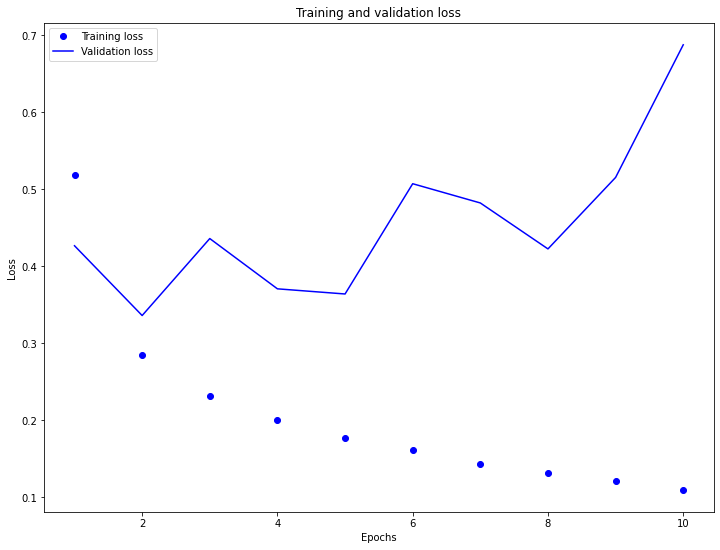

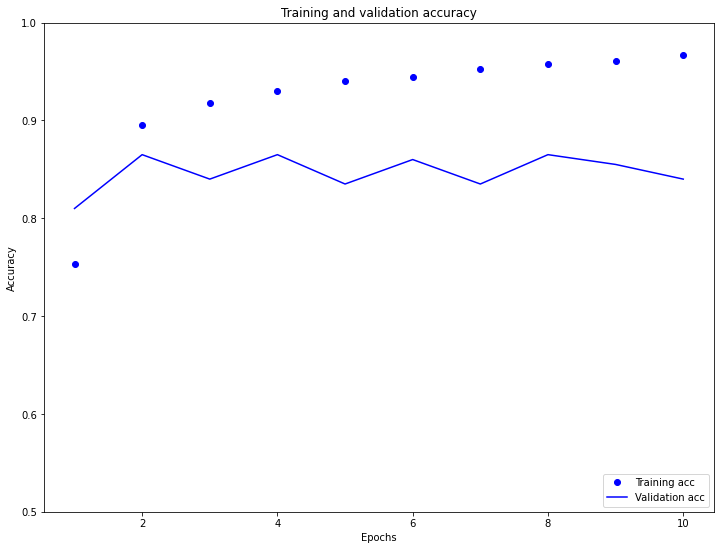

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Recuperar os embeddings aprendidos

Em seguida, vamos recuperar o embedding da palavra aprendida durante o treinamento. Esta será uma matriz de forma `(vocab_size, embedding-dimension)`.

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # formato: (vocab_size, embedding_dim)

(8185, 16)


Vamos agora escrever os pesos no disco. Para usar o [Embedding Projector] (http://projector.tensorflow.org), enviaremos dois arquivos em formato separado por tabulação: um arquivo de vetores (contendo a incorporação) e um arquivo de metadados (contendo as palavras).

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # pule o 0, está preenchido.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Se você estiver executando este tutorial em [Colaboratory] (https://colab.research.google.com), poderá usar o seguinte trecho para fazer o download desses arquivos na máquina local (ou usar o navegador de arquivos, * Exibir -> Tabela de conteúdo -> Navegador de arquivos *).

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize os embeddings

Para visualizar nossos embeddings, nós os carregaremos no projetor de embeddings.

Abra o [Embedding Projector] (http://projector.tensorflow.org/) (isso também pode ser executado em uma instância local do TensorBoard).

* Clique em "Carregar dados".

* Carregue os dois arquivos que criamos acima: `vecs.tsv` e` meta.tsv`.

Os embeddings que você treinou agora serão exibidas. Você pode procurar por palavras para encontrar os vizinhos mais próximos. Por exemplo, tente pesquisar por "beautiful". Você pode ver vizinhos como "wonderful".

Nota: seus resultados podem ser um pouco diferentes, dependendo de como os pesos foram inicializados aleatoriamente antes de treinar a camada de embedding.

Nota: experimentalmente, você poderá produzir combinações mais interpretáveis ​​usando um modelo mais simples. Tente excluir a camada `Dense (16)`, treinar novamente o modelo e visualizar os encaixes novamente.

<img src = "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt = "Captura de tela do projetor de embedding" width = "400" />

## Próximos passos


Este tutorial mostrou como treinar e visualizar o embedding de palavras do zero em um pequeno conjunto de dados.

* Para aprender sobre redes recorrentes, consulte o [Guia Keras RNN] (../../guide/keras/rnn.ipynb).

* Para saber mais sobre a classificação de texto (incluindo o fluxo de trabalho geral e se você está curioso para saber quando usar combinações versus codificações únicas), recomendamos esta prática guia de classificação de texto (https://developers.google.com/machine-learning/guides/text-classification/step-2-5).